# Sizing of Campus PV–Battery–Fuel Cell System Using Machine-Learning-Based Optimization


This notebook implements a campus-level sizing study for a hybrid energy system consisting of:

- A grid-connected PV plant
- A battery energy storage system (BESS)
- A fuel cell (FC) for backup / peak support

The workflow and cost model are inspired by the methodology in:

> “[Machine Learning-Based Sizing of a Renewable-Battery System for Grid-Connected Homes With Fast-Charging Electric Vehicle]” (referred to as **[1]** in this notebook).

We adapt the ideas from [1] to a **campus-scale** use-case (IIT Jodhpur) and use a Random Forest surrogate model to accelerate the search over (PV, FC, battery) sizes.


to read teh excel file

---



In [ ]:
!pip install openpyxl

 **TO check the file in the folder**

#Data load
List of the requaired data of campus

## 2. Data loading and campus load aggregation

In [ ]:
import os
folder = "/content/drive/MyDrive/B tech project/data"
print("Listing /mnt/data:")
for f in sorted(os.listdir(folder)):
    print(repr(f))


Listing /mnt/data:
'Building_CSVs'
'Campus_Total.csv'
'HOSTEL electricity DATA.xlsx'
'IITJodhpur_Sizing_Input.xlsx'
'Institute electricity charges.xlsx'
'Monthly Average Insolation.xlsx'
'all metered building electricity data.xlsx'
'mess electricity data.xlsx'
'solar electricity generated data.xlsx'


# This is only for the (CS , INS. MACH , EE , CI)
First for these department because these consume most load


## 3. PV generation template construction

This cell defines a **normalized PV power template** over the same time horizon as the load:

- If the workbook contains a `Generation_Hourly` sheet with a PV column, we normalize it to build a realistic PV pattern.
- Otherwise, we synthesize a diurnal PV profile using a sine-based function (sunrise at ~6:00, peak at noon, zero at night).

Mathematically, the synthetic template is of the form:

\[
P_{\text{PV,template}}(t) =
\max\left(0, \sin\left(\frac{2\pi}{24}\,(h_t - 6)\right)\right)
\]

where \(h_t\) is the hour-of-day of timestamp \(t\).  
We then scale this template by the decision variable \(P_{\text{PV,cap}}\) to obtain actual PV power.

A zero wind template is used here, but the structure allows adding wind in future work.


In [ ]:
# iitj_sizing_prep_minimal.py
"""
Prepare Excel + per-building CSV inputs for sizing using ONLY the required five files:
- all metered building electricity data.xlsx
- HOSTEL electricity DATA.xlsx
- Institute electricity charges.xlsx
- mess electricity data.xlsx
- solar electricity generated data.xlsx

Outputs:
- IITJodhpur_Sizing_Input.xlsx (multiple sheets)
- Building_CSVs/*.csv (per-building net-load hourly CSVs)
- Campus_Total.csv
"""

import os
import re
import numpy as np
import pandas as pd
from datetime import timedelta

# ---------------- CONFIGURE ----------------
DATA_PATH = "/content/drive/MyDrive/B tech project/data/"   # <- set to folder where the five Excel files are (must end with /)
OUT_XL = os.path.join(DATA_PATH, "IITJodhpur_Sizing_Input.xlsx")
OUT_CSV_DIR = os.path.join(DATA_PATH, "Building_CSVs")
OUT_CAMPUS = os.path.join(DATA_PATH, "Campus_Total.csv")

# Input files (must exist in DATA_PATH)
METERED_XL = os.path.join(DATA_PATH, "all metered building electricity data.xlsx")
HOSTEL_XL = os.path.join(DATA_PATH, "HOSTEL electricity DATA.xlsx")
CHARGES_XL = os.path.join(DATA_PATH, "Institute electricity charges.xlsx")
MESS_XL = os.path.join(DATA_PATH, "mess electricity data.xlsx")
SOLAR_XL = os.path.join(DATA_PATH, "solar electricity generated data.xlsx")

# Optional: if you have a campus hourly template named load_data.csv, put it in DATA_PATH.
TEMPLATE_HOURLY = os.path.join(DATA_PATH, "load_data.csv")  # optional

ASSUMED_CAMPUS_PV_SIZE_kW = 1000
ASSUMED_CAMPUS_WIND_SIZE_kW = 100

START_YEAR = 2025  # used to place timestamps (Jan-Sep 2025 expected)
# -------------------------------------------

def safe_mkdir(p):
    if not os.path.exists(p):
        os.makedirs(p)

def clean_name(s):
    if pd.isna(s): return ""
    return re.sub(r'[^\w\s-]', '', str(s)).strip()

def detect_blocks_metered(df):
    """
    Detect repeated blocks in metered workbook where each block starts with a 'Building/Service Name' column.
    Returns list of blocks (lists of column names).
    """
    cols = list(df.columns)
    blocks = []
    i = 0
    while i < len(cols):
        c = cols[i]
        if isinstance(c, str) and ('building' in c.lower() or 'service name' in c.lower()):
            block = [c]
            j = i + 1
            while j < len(cols):
                nxt = cols[j]
                if isinstance(nxt, str) and ('sr.' in nxt.lower() or ('building' in nxt.lower() and nxt != c)):
                    break
                block.append(nxt)
                j += 1
            blocks.append(block)
            i = j
        else:
            i += 1
    return blocks

def read_metered_and_extract():
    if not os.path.exists(METERED_XL):
        raise FileNotFoundError(f"Missing file: {METERED_XL}")
    raw = pd.read_excel(METERED_XL, header=0)
    blocks = detect_blocks_metered(raw)
    if not blocks:
        # fallback: assume first column is building name and next 9 columns are months + total
        cols = list(raw.columns)
        blocks = [cols[:11]]  # best-effort
    consolidated = []
    month_names = None
    for block in blocks:
        bcol = block[0]
        months = block[1:]
        # convert datetimes in header to month strings
        months_named = []
        for h in months:
            if isinstance(h, pd.Timestamp):
                months_named.append(h.strftime("%b-%Y"))
            else:
                months_named.append(str(h))
        df_block = raw[block].copy()
        rename_map = {bcol: "Building_Name"}
        rename_map.update({months[i]: months_named[i] for i in range(len(months))})
        df_block = df_block.rename(columns=rename_map)
        df_block["Building_Name"] = df_block["Building_Name"].astype(str).str.strip()
        # filter non-empty names
        df_block = df_block[df_block["Building_Name"].str.strip().astype(bool)]
        consolidated.append(df_block)
        if month_names is None:
            month_names = months_named
    df_all = pd.concat(consolidated, ignore_index=True, sort=False)
    # Keep Building_Name and month columns + TOTAL if present
    keep_cols = ["Building_Name"] + [c for c in df_all.columns if c in (month_names or []) or 'TOTAL' in str(c).upper()]
    df_all = df_all.loc[:, keep_cols]
    # numeric coercion
    for c in df_all.columns:
        if c != "Building_Name":
            df_all[c] = pd.to_numeric(df_all[c], errors='coerce')
    # Ensure TOTAL exists (compute if missing)
    total_cols = [c for c in df_all.columns if str(c).upper().startswith("TOTAL")]
    if not total_cols:
        month_cols = [c for c in df_all.columns if c != "Building_Name"]
        df_all["TOTAL"] = df_all[month_cols].sum(axis=1, skipna=True)
    else:
        df_all = df_all.rename(columns={total_cols[0]: "TOTAL"})
    return df_all, month_names

def filter_engineering(df):
    keywords = ['electrical', 'computer', 'mechanical', 'cse', 'civil', 'workshop', 'instrumentation']
    mask = df['Building_Name'].str.lower().fillna("").apply(lambda s: any(kw in s for kw in keywords))
    eng = df[mask].copy()
    if eng.empty:
        # fallback: take top N rows (safe)
        eng = df.head(10).copy()
    return eng

def load_template_hourly():
    if not os.path.exists(TEMPLATE_HOURLY):
        return None
    try:
        tmpl = pd.read_csv(TEMPLATE_HOURLY)
    except Exception:
        tmpl = pd.read_csv(TEMPLATE_HOURLY, engine='python')
    # find timestamp column
    ts_col = None
    for c in tmpl.columns:
        if 'time' in c.lower() or 'timestamp' in c.lower() or 'date' in c.lower():
            ts_col = c; break
    if ts_col is None:
        ts_col = tmpl.columns[0]
    # find load column
    load_col = None
    for c in tmpl.columns:
        if 'load' in c.lower() or 'campus' in c.lower():
            load_col = c; break
    if load_col is None and len(tmpl.columns) > 1:
        load_col = tmpl.columns[1]
    tmpl[ts_col] = pd.to_datetime(tmpl[ts_col], errors='coerce')
    tmpl = tmpl.dropna(subset=[ts_col]).set_index(ts_col).sort_index()
    if load_col is None:
        tmpl['Campus_Load_kW'] = 1.0
    else:
        tmpl = tmpl.rename(columns={load_col:'Campus_Load_kW'})
    # ensure year set to START_YEAR for months Jan-Sep
    tmpl.index = tmpl.index.map(lambda t: t.replace(year=START_YEAR) if pd.notna(t) else t)
    tmpl = tmpl[(tmpl.index.month >= 1) & (tmpl.index.month <= 9)]
    tmpl['Month'] = tmpl.index.month
    return tmpl

def synthesize_department_hourly(eng_df, month_names, tmpl):
    # months Jan-Sep expected in month_names (month_names[0] -> Jan)
    days_per_month = [31,28,31,30,31,30,31,31,30]  # Jan-Sep 2025
    hours_in_month = {i+1: days_per_month[i]*24 for i in range(9)}
    frames = []
    if tmpl is None:
        # even distribution fallback for each building
        for _, r in eng_df.iterrows():
            bname = r['Building_Name']
            rows = []
            for m in range(1,10):
                total_kwh = float(r[month_names[m-1]]) if (month_names and month_names[m-1] in eng_df.columns and pd.notna(r[month_names[m-1]])) else 0.0
                hcount = hours_in_month[m]
                per_hour = total_kwh / hcount if hcount>0 else 0.0
                # produce timestamps sequentially for that month
                for day in range(days_per_month[m-1]):
                    for hr in range(24):
                        ts = pd.Timestamp(year=START_YEAR, month=m, day=1) + pd.Timedelta(days=day, hours=hr)
                        rows.append((ts, bname, per_hour))
            df_b = pd.DataFrame(rows, columns=['Timestamp','Building_Name','Building_Load_kW'])
            frames.append(df_b)
    else:
        template_monthly_sum = tmpl.groupby('Month')['Campus_Load_kW'].sum().to_dict()
        for _, r in eng_df.iterrows():
            bname = r['Building_Name']
            df_b = pd.DataFrame(index=tmpl.index)
            df_b['Timestamp'] = df_b.index
            df_b['Building_Name'] = bname
            df_b['Building_Load_kW'] = 0.0
            for m in range(1,10):
                building_total = float(r[month_names[m-1]]) if (month_names and month_names[m-1] in eng_df.columns and pd.notna(r[month_names[m-1]])) else 0.0
                templ_total = template_monthly_sum.get(m, 0.0)
                if templ_total <= 0 or building_total == 0:
                    scale = 0.0
                else:
                    scale = building_total / templ_total
                mask = (tmpl['Month'] == m)
                df_b.loc[mask, 'Building_Load_kW'] = tmpl.loc[mask, 'Campus_Load_kW'] * scale
            df_b = df_b.reset_index(drop=True)
            frames.append(df_b[['Timestamp','Building_Name','Building_Load_kW']])
    dept_hourly = pd.concat(frames, ignore_index=True)
    # pivot to have one column per building (Timestamp + building columns)
    pivot = dept_hourly.pivot(index='Timestamp', columns='Building_Name', values='Building_Load_kW').reset_index().rename_axis(None, axis=1)
    return pivot

def build_generation_hourly(pivot, solar_xl_path):
    # Create Generation_Hourly with simple distribution from monthly solar totals if provided
    gen = pd.DataFrame({'Timestamp': pivot['Timestamp']})
    gen['Month'] = pd.to_datetime(gen['Timestamp']).dt.month
    gen['PV_Gen_kW_Base'] = 0.0
    gen['Wind_Gen_kW_Base'] = 0.0
    # try read solar monthly totals
    if os.path.exists(solar_xl_path):
        try:
            df_sol = pd.read_excel(solar_xl_path, sheet_name=0)
            # try find a column that indicates monthly generation
            candidate_cols = [c for c in df_sol.columns if 'unit' in str(c).lower() or 'generated' in str(c).lower() or 'kwh' in str(c).lower()]
            if candidate_cols:
                col = candidate_cols[0]
                # if there is Month column, map; otherwise take first 9 values as Jan-Sep
                if 'Month' in df_sol.columns:
                    solar_monthly = {}
                    for _, r in df_sol.iterrows():
                        try:
                            m = int(r['Month'])
                            if 1 <= m <= 12:
                                solar_monthly[m] = float(r[col])
                        except: pass
                else:
                    vals = df_sol[col].dropna().values
                    solar_monthly = {i+1: float(vals[i]) for i in range(min(9,len(vals)))}
                # distribute monthly totals evenly among hours of that month
                for m, tot in solar_monthly.items():
                    mask = gen['Month']==m
                    count = mask.sum()
                    if count>0:
                        gen.loc[mask, 'PV_Gen_kW_Base'] = tot / count
        except Exception:
            pass
    return gen[['Timestamp','PV_Gen_kW_Base','Wind_Gen_kW_Base']]

def create_cost_sheet(charges_xl):
    avg_tariff = np.nan
    if os.path.exists(charges_xl):
        try:
            df = pd.read_excel(charges_xl, sheet_name=0)
            nums = df.select_dtypes(include=[np.number]).columns.tolist()
            if len(nums) >= 2:
                total_kwh = pd.to_numeric(df[nums[0]].dropna().iloc[-1], errors='coerce')
                total_rs = pd.to_numeric(df[nums[1]].dropna().iloc[-1], errors='coerce')
                if pd.notna(total_kwh) and total_kwh > 0:
                    avg_tariff = total_rs / total_kwh
        except Exception:
            pass
    cost_df = pd.DataFrame({
        'Parameter': ['Grid Tariff (Rs/kWh)'],
        'Value': [avg_tariff],
        'Units': ['Rs/kWh']
    })
    return cost_df

def write_outputs(dept_monthly, summary, pivot, gen, cost_df, log_entries):
    safe_mkdir(OUT_CSV_DIR)
    writer = pd.ExcelWriter(OUT_XL, engine='openpyxl')
    dept_monthly.to_excel(writer, sheet_name="Department_Monthly", index=False)
    summary.to_excel(writer, sheet_name="Department_Summary", index=False)
    pivot.to_excel(writer, sheet_name="Department_Hourly", index=False)
    gen.to_excel(writer, sheet_name="Generation_Hourly", index=False)
    cost_df.to_excel(writer, sheet_name="Cost_Data", index=False)
    pd.DataFrame({'Log': log_entries}).to_excel(writer, sheet_name="Creation_Log", index=False)
    writer.close()

    # create per-building CSVs: compute Net_Load = Building_Load - PV_alloc - Wind_alloc
    df_all = pivot.merge(gen, on='Timestamp', how='left')
    total_energy = summary['Annual_Energy_kWh'].sum()
    summary['Load_Share'] = summary['Annual_Energy_kWh'] / (total_energy if total_energy>0 else 1.0)
    building_cols = [c for c in df_all.columns if c not in ['Timestamp','PV_Gen_kW_Base','Wind_Gen_kW_Base']]
    count = 0
    for bcol in building_cols[1:]:  # skip Timestamp
        bname = bcol
        clean_file = re.sub(r'[^a-zA-Z0-9_-]', '_', clean_name(bname))
        df_b = pd.DataFrame()
        df_b['Timestamp'] = df_all['Timestamp']
        df_b['Building_Load_kW'] = df_all[bcol].fillna(0.0)
        share_row = summary[summary['Building_Name']==bname]
        share_val = float(share_row['Load_Share'].values[0]) if not share_row.empty else 0.0
        pv_alloc = ASSUMED_CAMPUS_PV_SIZE_kW * share_val
        wind_alloc = ASSUMED_CAMPUS_WIND_SIZE_kW * share_val
        df_b['Net_Load_kW'] = df_b['Building_Load_kW'] - (df_all['PV_Gen_kW_Base'] * pv_alloc) - (df_all['Wind_Gen_kW_Base'] * wind_alloc)
        out_csv = os.path.join(OUT_CSV_DIR, f"{clean_file}.csv")
        df_b[['Timestamp','Net_Load_kW']].to_csv(out_csv, index=False)
        count += 1

    # campus total
    df_campus = pd.DataFrame()
    df_campus['Timestamp'] = df_all['Timestamp']
    loads = df_all[building_cols[1:]].sum(axis=1)
    df_campus['Total_Building_Load_kW'] = loads
    df_campus['Total_PV_Gen_kW'] = df_all['PV_Gen_kW_Base'] * ASSUMED_CAMPUS_PV_SIZE_kW
    df_campus['Total_Wind_Gen_kW'] = df_all['Wind_Gen_kW_Base'] * ASSUMED_CAMPUS_WIND_SIZE_kW
    df_campus['Total_Net_Load_kW'] = df_campus['Total_Building_Load_kW'] - df_campus['Total_PV_Gen_kW'] - df_campus['Total_Wind_Gen_kW']
    df_campus.to_csv(OUT_CAMPUS, index=False)
    return count

def main():
    log = []
    # read metered and extract
    df_all, month_names = read_metered_and_extract()
    log.append(f"Read metered file and extracted {len(df_all)} rows.")

    # select engineering buildings
    eng = filter_engineering(df_all)
    log.append(f"Selected {len(eng)} engineering-related buildings.")

    # create summary
    days_per_month = [31,28,31,30,31,30,31,31,30]
    hours_total = sum(days_per_month)*24
    summary = pd.DataFrame()
    summary['Building_Name'] = eng['Building_Name'].values
    summary['Annual_Energy_kWh'] = eng['TOTAL'].astype(float).values
    summary['Hours_in_period'] = hours_total
    summary['Avg_Load_kW'] = summary['Annual_Energy_kWh'] / hours_total
    summary['Peak_estimate_kW'] = 1.5 * summary['Avg_Load_kW']
    summary['Notes'] = f"Jan-Sep 2025 ({hours_total} hours). Peak=1.5x Avg."

    # load template hourly (optional)
    tmpl = load_template_hourly()
    if tmpl is None:
        log.append("No hourly template found: using even hourly distribution fallback.")
    else:
        log.append("Hourly template loaded and used for synthesis.")

    # synthesize department hourly pivot
    pivot = synthesize_department_hourly(eng, month_names, tmpl)
    log.append(f"Department_Hourly synthesized: shape {pivot.shape}")

    # build generation hourly
    gen = build_generation_hourly(pivot, SOLAR_XL)
    log.append("Generation_Hourly created (PV monthly distributed if present).")

    # cost sheet
    cost_df = create_cost_sheet(CHARGES_XL)
    log.append("Cost data prepared.")

    # write outputs
    write_outputs(eng, summary, pivot, gen, cost_df, log)
    written = create_per_building_count = len([f for f in os.listdir(OUT_CSV_DIR) if f.endswith('.csv')]) if os.path.exists(OUT_CSV_DIR) else 0

    print("=== Completed ===")
    print(f"Workbook: {OUT_XL}")
    print(f"Per-building CSVs created: {create_per_building_count}")
    print(f"Campus total CSV: {OUT_CAMPUS}")
    print("Top log lines:")
    for l in log[:10]:
        print(" -", l)

if __name__ == "__main__":
    main()


=== Completed ===
Workbook: /content/drive/MyDrive/B tech project/data/IITJodhpur_Sizing_Input.xlsx
Per-building CSVs created: 4
Campus total CSV: /content/drive/MyDrive/B tech project/data/Campus_Total.csv
Top log lines:
 - Read metered file and extracted 156 rows.
 - Selected 5 engineering-related buildings.
 - No hourly template found: using even hourly distribution fallback.
 - Department_Hourly synthesized: shape (6552, 6)
 - Generation_Hourly created (PV monthly distributed if present).
 - Cost data prepared.


# For all building

In [ ]:
# select_important_buildings_iitj.py
"""
Select 'important' buildings (engineering keywords + top N consumers) from the
metered workbook and produce the same IITJodhpur_Sizing_Input outputs but
for a broader set of important buildings.

Inputs (must be in DATA_PATH):
- all metered building electricity data.xlsx
- HOSTEL electricity DATA.xlsx
- Institute electricity charges.xlsx
- mess electricity data.xlsx
- solar electricity generated data.xlsx

Outputs:
- IITJodhpur_Sizing_Input.xlsx (sheets: Department_Monthly, Department_Summary, Department_Hourly, Generation_Hourly, Cost_Data, Creation_Log)
- Building_CSVs/*.csv (per-building net-load hourly CSVs)
- Campus_Total.csv
"""

import os, re, numpy as np, pandas as pd
from datetime import timedelta

# ---------- CONFIG ----------
DATA_PATH = "/content/drive/MyDrive/B tech project/data/"   # update if needed
METERED_XL = os.path.join(DATA_PATH, "all metered building electricity data.xlsx")
SOLAR_XL = os.path.join(DATA_PATH, "solar electricity generated data.xlsx")
CHARGES_XL = os.path.join(DATA_PATH, "Institute electricity charges.xlsx")
TEMPLATE_HOURLY = os.path.join(DATA_PATH, "load_data.csv")  # optional
OUT_XL = os.path.join(DATA_PATH, "IITJodhpur_Sizing_Input.xlsx")
OUT_DIR = os.path.join(DATA_PATH, "Building_CSVs")
OUT_CAMPUS = os.path.join(DATA_PATH, "Campus_Total.csv")

START_YEAR = 2025
ASSUMED_CAMPUS_PV_SIZE_kW = 1000
ASSUMED_CAMPUS_WIND_SIZE_kW = 100

TOP_N = 15   # number of top consumers to include (change as needed)
# ----------------------------

def safe_mkdir(p):
    if not os.path.exists(p):
        os.makedirs(p)

def clean_name(s):
    if pd.isna(s):
        return ""
    return re.sub(r'[^\w\s-]', '', str(s)).strip()

def detect_blocks_metered(df):
    cols = list(df.columns)
    blocks = []
    i = 0
    while i < len(cols):
        c = cols[i]
        if isinstance(c, str) and ('building' in c.lower() or 'service name' in c.lower()):
            block = [c]
            j = i+1
            while j < len(cols):
                nxt = cols[j]
                # stop conditions
                if isinstance(nxt, str) and ('sr.' in nxt.lower() or ('building' in nxt.lower() and nxt != c)):
                    break
                block.append(nxt); j += 1
            blocks.append(block)
            i = j
        else:
            i += 1
    return blocks

def read_metered_all():
    if not os.path.exists(METERED_XL):
        raise FileNotFoundError(f"Missing: {METERED_XL}")
    raw = pd.read_excel(METERED_XL, header=0)
    blocks = detect_blocks_metered(raw)
    if not blocks:
        # fallback: assume first column building, next 9 months + total
        cols = list(raw.columns)
        blocks = [cols[:11]]
    consolidated = []
    month_names = None
    for block in blocks:
        bcol = block[0]; months = block[1:]
        months_named = []
        for h in months:
            if isinstance(h, pd.Timestamp):
                months_named.append(h.strftime("%b-%Y"))
            else:
                months_named.append(str(h))
        df_block = raw[block].copy()
        rename_map = {bcol: "Building_Name"}
        rename_map.update({months[i]: months_named[i] for i in range(len(months))})
        df_block = df_block.rename(columns=rename_map)
        df_block["Building_Name"] = df_block["Building_Name"].astype(str).str.strip()
        df_block = df_block[df_block["Building_Name"].str.strip().astype(bool)]
        consolidated.append(df_block)
        if month_names is None: month_names = months_named
    df_all = pd.concat(consolidated, ignore_index=True, sort=False)
    # keep building + months + TOTAL if present
    keep_cols = ["Building_Name"] + [c for c in df_all.columns if c in (month_names or []) or 'TOTAL' in str(c).upper()]
    df_all = df_all.loc[:, keep_cols]
    # numeric conversion
    for c in df_all.columns:
        if c != "Building_Name":
            df_all[c] = pd.to_numeric(df_all[c], errors='coerce')
    # ensure TOTAL
    total_cols = [c for c in df_all.columns if str(c).upper().startswith("TOTAL")]
    if not total_cols:
        month_cols = [c for c in df_all.columns if c != "Building_Name"]
        df_all["TOTAL"] = df_all[month_cols].sum(axis=1, skipna=True)
    else:
        df_all = df_all.rename(columns={total_cols[0]:"TOTAL"})
    return df_all, month_names

def pick_important_buildings(df_all, month_names, top_n=TOP_N):
    # 1) engineering keywords
    keywords = ['electrical', 'computer', 'mechanical', 'cse', 'civil', 'workshop', 'instrumentation', 'library', 'hostel', 'mess', 'admin']
    mask_kw = df_all['Building_Name'].str.lower().fillna("").apply(lambda s: any(kw in s for kw in keywords))
    eng = df_all[mask_kw].copy()
    # 2) top N by TOTAL
    ranked = df_all.sort_values('TOTAL', ascending=False)
    topn = ranked.head(top_n).copy()
    # Union of both sets -> preserve original order by TOTAL descending
    combined_names = pd.concat([eng, topn]).drop_duplicates(subset=['Building_Name'])
    combined = combined_names.sort_values('TOTAL', ascending=False).reset_index(drop=True)
    return combined

def load_template_hourly():
    if not os.path.exists(os.path.join(DATA_PATH, "load_data.csv")):
        return None
    try:
        tmpl = pd.read_csv(os.path.join(DATA_PATH, "load_data.csv"))
    except Exception:
        tmpl = pd.read_csv(os.path.join(DATA_PATH, "load_data.csv"), engine='python')
    # detect timestamp & load column
    ts_col = None
    for c in tmpl.columns:
        if 'time' in c.lower() or 'timestamp' in c.lower() or 'date' in c.lower():
            ts_col = c; break
    if ts_col is None: ts_col = tmpl.columns[0]
    load_col = None
    for c in tmpl.columns:
        if 'load' in c.lower() or 'campus' in c.lower():
            load_col = c; break
    if load_col is None and len(tmpl.columns)>1: load_col = tmpl.columns[1]
    tmpl[ts_col] = pd.to_datetime(tmpl[ts_col], errors='coerce')
    tmpl = tmpl.dropna(subset=[ts_col]).set_index(ts_col).sort_index()
    if load_col is None:
        tmpl['Campus_Load_kW'] = 1.0
    else:
        tmpl = tmpl.rename(columns={load_col:'Campus_Load_kW'})
    tmpl.index = tmpl.index.map(lambda t: t.replace(year=START_YEAR) if pd.notna(t) else t)
    tmpl = tmpl[(tmpl.index.month >=1) & (tmpl.index.month<=9)]
    tmpl['Month'] = tmpl.index.month
    return tmpl

def synthesize_hourly(selected_df, month_names, tmpl):
    days_per_month = [31,28,31,30,31,30,31,31,30]
    hours_in_month = {i+1: days_per_month[i]*24 for i in range(9)}
    frames = []
    if tmpl is None:
        for _, r in selected_df.iterrows():
            bname = r['Building_Name']
            rows = []
            for m in range(1,10):
                total_kwh = float(r[month_names[m-1]]) if (month_names and month_names[m-1] in selected_df.columns and pd.notna(r[month_names[m-1]])) else 0.0
                hcount = hours_in_month[m]
                per_hour = total_kwh / hcount if hcount>0 else 0.0
                for day in range(days_per_month[m-1]):
                    for hr in range(24):
                        ts = pd.Timestamp(year=START_YEAR, month=m, day=1) + pd.Timedelta(days=day, hours=hr)
                        rows.append((ts, bname, per_hour))
            df_b = pd.DataFrame(rows, columns=['Timestamp','Building_Name','Building_Load_kW'])
            frames.append(df_b)
    else:
        t_month_sum = tmpl.groupby('Month')['Campus_Load_kW'].sum().to_dict()
        for _, r in selected_df.iterrows():
            bname = r['Building_Name']
            df_b = pd.DataFrame(index=tmpl.index)
            df_b['Timestamp'] = df_b.index
            df_b['Building_Name'] = bname
            df_b['Building_Load_kW'] = 0.0
            for m in range(1,10):
                building_total = float(r[month_names[m-1]]) if (month_names and month_names[m-1] in selected_df.columns and pd.notna(r[month_names[m-1]])) else 0.0
                templ_total = t_month_sum.get(m, 0.0)
                if templ_total <= 0 or building_total == 0:
                    scale = 0.0
                else:
                    scale = building_total / templ_total
                mask = (tmpl['Month'] == m)
                df_b.loc[mask, 'Building_Load_kW'] = tmpl.loc[mask, 'Campus_Load_kW'] * scale
            df_b = df_b.reset_index(drop=True)
            frames.append(df_b[['Timestamp','Building_Name','Building_Load_kW']])
    dept_hourly = pd.concat(frames, ignore_index=True)
    pivot = dept_hourly.pivot(index='Timestamp', columns='Building_Name', values='Building_Load_kW').reset_index().rename_axis(None, axis=1)
    return pivot

def build_generation_hourly(pivot, solar_xl):
    gen = pd.DataFrame({'Timestamp': pivot['Timestamp']})
    gen['Month'] = pd.to_datetime(gen['Timestamp']).dt.month
    gen['PV_Gen_kW_Base'] = 0.0
    gen['Wind_Gen_kW_Base'] = 0.0
    # try solar monthly totals
    if os.path.exists(solar_xl):
        try:
            df_s = pd.read_excel(solar_xl, sheet_name=0)
            cand = [c for c in df_s.columns if 'unit' in str(c).lower() or 'generated' in str(c).lower() or 'kwh' in str(c).lower()]
            if cand:
                col = cand[0]
                if 'Month' in df_s.columns:
                    solar_month = {int(r['Month']): float(r[col]) for _,r in df_s.iterrows() if not pd.isna(r.get('Month'))}
                else:
                    vals = df_s[col].dropna().values
                    solar_month = {i+1: float(vals[i]) for i in range(min(9,len(vals)))}
                for m, tot in solar_month.items():
                    mask = gen['Month'] == m
                    cnt = mask.sum()
                    if cnt>0:
                        gen.loc[mask, 'PV_Gen_kW_Base'] = tot / cnt
        except Exception:
            pass
    return gen[['Timestamp','PV_Gen_kW_Base','Wind_Gen_kW_Base']]

def create_cost_df(charges_xl):
    avg_tariff = np.nan
    if os.path.exists(charges_xl):
        try:
            df = pd.read_excel(charges_xl, sheet_name=0)
            nums = df.select_dtypes(include=[np.number]).columns.tolist()
            if len(nums)>=2:
                total_kwh = pd.to_numeric(df[nums[0]].dropna().iloc[-1], errors='coerce')
                total_rs = pd.to_numeric(df[nums[1]].dropna().iloc[-1], errors='coerce')
                if pd.notna(total_kwh) and total_kwh>0:
                    avg_tariff = total_rs / total_kwh
        except Exception:
            pass
    return pd.DataFrame({'Parameter':['Grid Tariff (Rs/kWh)'],'Value':[avg_tariff],'Units':['Rs/kWh']})

def write_results(selected_df, month_names, pivot, gen, summary, cost_df, log):
    safe_mkdir(OUT_DIR)
    writer = pd.ExcelWriter(OUT_XL, engine='openpyxl')
    selected_df.to_excel(writer, sheet_name="Department_Monthly", index=False)
    summary.to_excel(writer, sheet_name="Department_Summary", index=False)
    pivot.to_excel(writer, sheet_name="Department_Hourly", index=False)
    gen.to_excel(writer, sheet_name="Generation_Hourly", index=False)
    cost_df.to_excel(writer, sheet_name="Cost_Data", index=False)
    pd.DataFrame({'Log': log}).to_excel(writer, sheet_name="Creation_Log", index=False)
    writer.close()

    df_all = pivot.merge(gen, on='Timestamp', how='left')
    total_energy = summary['Annual_Energy_kWh'].sum()
    summary['Load_Share'] = summary['Annual_Energy_kWh'] / (total_energy if total_energy>0 else 1.0)
    building_cols = [c for c in df_all.columns if c not in ['Timestamp','PV_Gen_kW_Base','Wind_Gen_kW_Base']]
    count = 0
    for bcol in building_cols[1:]:
        bname = bcol
        clean_file = re.sub(r'[^a-zA-Z0-9_-]', '_', clean_name(bname))
        df_b = pd.DataFrame()
        df_b['Timestamp'] = df_all['Timestamp']
        df_b['Building_Load_kW'] = df_all[bcol].fillna(0.0)
        share_row = summary[summary['Building_Name']==bname]
        share_val = float(share_row['Load_Share'].values[0]) if not share_row.empty else 0.0
        pv_alloc = ASSUMED_CAMPUS_PV_SIZE_kW * share_val
        wind_alloc = ASSUMED_CAMPUS_WIND_SIZE_kW * share_val
        df_b['Net_Load_kW'] = df_b['Building_Load_kW'] - (df_all['PV_Gen_kW_Base'] * pv_alloc) - (df_all['Wind_Gen_kW_Base'] * wind_alloc)
        out_csv = os.path.join(OUT_DIR, f"{clean_file}.csv")
        df_b[['Timestamp','Net_Load_kW']].to_csv(out_csv, index=False)
        count += 1

    # campus total
    df_campus = pd.DataFrame()
    df_campus['Timestamp'] = df_all['Timestamp']
    df_campus['Total_Building_Load_kW'] = df_all[building_cols[1:]].sum(axis=1)
    df_campus['Total_PV_Gen_kW'] = df_all['PV_Gen_kW_Base'] * ASSUMED_CAMPUS_PV_SIZE_kW
    df_campus['Total_Wind_Gen_kW'] = df_all['Wind_Gen_kW_Base'] * ASSUMED_CAMPUS_WIND_SIZE_kW
    df_campus['Total_Net_Load_kW'] = df_campus['Total_Building_Load_kW'] - df_campus['Total_PV_Gen_kW'] - df_campus['Total_Wind_Gen_kW']
    df_campus.to_csv(OUT_CAMPUS, index=False)
    return count

def main():
    log = []
    df_all, month_names = read_metered_all()
    log.append(f"Read metered workbook, found {len(df_all)} rows.")
    selected = pick_important_buildings(df_all, month_names, TOP_N)
    log.append(f"Selected {len(selected)} important buildings (union of engineering keywords + top {TOP_N}).")
    # Summary calc
    days_per_month = [31,28,31,30,31,30,31,31,30]
    hours_total = sum(days_per_month)*24
    summary = pd.DataFrame()
    summary['Building_Name'] = selected['Building_Name'].values
    summary['Annual_Energy_kWh'] = selected['TOTAL'].astype(float).values
    summary['Hours_in_period'] = hours_total
    summary['Avg_Load_kW'] = summary['Annual_Energy_kWh'] / hours_total
    summary['Peak_estimate_kW'] = 1.5 * summary['Avg_Load_kW']
    summary['Notes'] = f"Jan-Sep 2025 ({hours_total} hours). Peak=1.5x Avg."

    tmpl = load_template_hourly()
    if tmpl is None:
        log.append("No hourly template found; using even distribution fallback.")
    else:
        log.append("Hourly template loaded for realistic shape scaling.")

    pivot = synthesize_hourly(selected, month_names, tmpl)
    log.append(f"Department_Hourly synthesized: {pivot.shape}")

    gen = build_generation_hourly(pivot, SOLAR_XL)
    cost_df = create_cost_df(CHARGES_XL)
    written_count = write_results(selected, month_names, pivot, gen, summary, cost_df, log)
    print("=== Done ===")
    print(f"Selected buildings: {len(selected)}; per-building CSVs produced: {written_count}")
    print("Top selection preview:")
    print(selected[['Building_Name','TOTAL']].head(20).to_string(index=False))

if __name__ == "__main__":
    main()


    # -----------------------------------------
    # After CSVs and Excel have been created
    # -----------------------------------------
    # count = write_outputs(selected, summary, pivot, gen, cost_df, log)

    # ---------- SUMMARY (inside main) ----------
    print("\n")
    print("============================================")
    print("        ✅ PROCESSING SUMMARY REPORT")
    print("============================================")
    print(" Total buildings processed       "  )
    print(" Per-building CSV files generated " )
    print(" Months processed                "  )
    print(" Hourly data source              "  )
    print("\n📘 Excel workbook created:")
    # print(f"   → {OUT_XL}")

    print("\n📂 Per-building CSV folder:")
    # print(f"   → {OUT_DIR}")

    print("\n🏫 Campus total load file:")
    # print(f"   → {OUT_CAMPUS}")/

    print("\n📝 Sheets included in Excel:")
    print("   - Department_Monthly")
    print("   - Department_Summary")
    print("   - Department_Hourly")
    print("   - Generation_Hourly")
    print("   - Cost_Data")
    print("   - Creation_Log")

    print("\n🎯 Important buildings processed:")
    # print(selected[['Building_Name','TOTAL']]

    print("\n============================================")
    print("        🎉 ALL FILES CREATED SUCCESSFULLY!")
    print("============================================\n")


=== Done ===
Selected buildings: 16; per-building CSVs produced: 15
Top selection preview:
            Building_Name       TOTAL
                      nan 27172643.59
          Computer Center  7177130.54
                Chemistry  3427302.65
                   C.S.E.  2726127.60
          Instrumentation  1962184.37
    Mechanical Department  1690048.08
    Electrical Department  1166389.57
                   L.H.B.  1088302.43
    Bioscience Department  1039010.26
                 Libraray   851353.00
      Admin Building East   744174.22
         Basic Department   730743.16
      Admin Building West   620831.42
                KV School   452619.53
        BERM (E-1 to E-8)   443971.15
Workshop Civil Department    67577.83


        ✅ PROCESSING SUMMARY REPORT
 Total buildings processed       
 Per-building CSV files generated 
 Months processed                
 Hourly data source              

📘 Excel workbook created:

📂 Per-building CSV folder:

🏫 Campus total load file:

📝 She

# Machine_Learning-Based_Sizing_of_a_Renewable-Battery_System_fsolar_And_Fuel_cell

#EMS / dispatch model (PV + FC + battery + grid)

##  Energy management strategy (EMS): PV + Fuel Cell + Battery + Grid

This function implements an **hourly dispatch algorithm** for the campus hybrid system with the following priority:

1. **PV supplies load first.**
2. **Fuel cell supplies remaining load up to its rated capacity** (FC-before-battery strategy).
3. **Battery discharges** to cover any residual deficit, limited by available state of charge and max power.
4. Any leftover deficit is imported from the grid.
5. Any PV surplus after serving load is used to **charge the battery**, then any excess is exported to the grid.

The state of charge (SOC) evolves as:

\[
\text{SOC}_{t+1} = \text{SOC}_t + \eta_\text{ch} P_\text{ch}\Delta t - \frac{1}{\eta_\text{dis}}P_\text{dis}\Delta t
\]

subject to \(0 \le \text{SOC}_t \le E_\text{batt}\).

The function outputs:

- Total imported and exported energy
- PV and FC generation
- Served load
- SOC trajectory over the year

This is the core **simulation engine** that links design variables (PV, FC, battery sizes) to performance metrics, analogous to the time-series simulations in [1].


In [ ]:
# --- SANITIZE COSTS & TARIFFS (run once before sizing) ---
import math

def safe_float(x, fallback):
    try:
        if x is None: return fallback
        if isinstance(x, float) and math.isnan(x): return fallback
        return float(x)
    except Exception:
        return fallback

# set safe defaults (tune if you want)
DEFAULT_CAPEX_PV = 500.0
DEFAULT_CAPEX_WIND = 1500.0
DEFAULT_CAPEX_BATT = 300.0
DEFAULT_IMP = 0.10
DEFAULT_EXP = 0.033

# if cost_params exists in your script, sanitize it; otherwise define it
if 'cost_params' in globals():
    cost_params['pv_capex_usd_per_kw']  = safe_float(cost_params.get('pv_capex_usd_per_kw'), DEFAULT_CAPEX_PV)
    cost_params['wind_capex_usd_per_kw']= safe_float(cost_params.get('wind_capex_usd_per_kw'), DEFAULT_CAPEX_WIND)
    cost_params['batt_capex_usd_per_kwh']= safe_float(cost_params.get('batt_capex_usd_per_kwh'), DEFAULT_CAPEX_BATT)
else:
    cost_params = {
        'pv_capex_usd_per_kw': DEFAULT_CAPEX_PV,
        'wind_capex_usd_per_kw': DEFAULT_CAPEX_WIND,
        'batt_capex_usd_per_kwh': DEFAULT_CAPEX_BATT
    }

# sanitize tariff variables (if they exist)
if 'tariff_import' in globals():
    tariff_import = safe_float(tariff_import, DEFAULT_IMP)
else:
    tariff_import = DEFAULT_IMP

if 'tariff_export' in globals():
    tariff_export = safe_float(tariff_export, DEFAULT_EXP)
else:
    tariff_export = DEFAULT_EXP

print("Sanitized cost_params:", cost_params)
print("Sanitized tariffs (USD/kWh): import=", tariff_import, " export=", tariff_export)
# --- end sanitize ---


Sanitized cost_params: {'pv_capex_usd_per_kw': 500.0, 'wind_capex_usd_per_kw': 1500.0, 'batt_capex_usd_per_kwh': 300.0}
Sanitized tariffs (USD/kWh): import= 0.1  export= 0.033


#Battery, fuel cell, PV

Campus hourly load = sum of all department hourly loads from Department_Hourly sheet.

PV + Battery are primary: PV generation charges battery / serves load.

Fuel Cell (FC) is modelled as backup/emergency:

# Pseudo-code (per hour):**

1. Compute PV generation from template and PV size.
2. If PV ≥ load:
   - Serve load with PV.
   - Charge battery with surplus (up to limits).
   - Export any remaining surplus to grid.
3. Else (PV < load):
   - Take power from FC (up to FC rating).
   - Cover remaining deficit with battery discharge.
   - Import any remaining deficit from grid.
4. Update SOC and record energy flows.


## . ML-based sizing search with Random Forest surrogate

Exhaustively exploring all combinations of PV, FC and battery sizes is computationally expensive.  
Following the machine-learning-based approach of [1], we use a **two-stage search:**

1. **Initial random sampling**
   - Draw `N_SAMPLES` random points in the design space:
     \((P_{\text{PV,cap}}, P_{\text{FC,cap}}, E_{\text{batt}})\).
   - Evaluate each point with the EMS and cost model.
   - Apply an autonomy constraint:
     \[
     E_{\text{batt}} \ge P_\text{night,avg} \times \text{AUTONOMY\_HOURS}
     \]

2. **Surrogate model refinement**
   - Fit a Random Forest Regressor to predict COE from the sampled designs.
   - Select the best `REFINE_TOP_K` designs.
   - Generate refined candidate points around these designs using Gaussian perturbations.
   - Use the surrogate to rank these refined points, then **re-simulate** the most promising ones with the full EMS.

Finally we select the design with the **lowest COE** that satisfies the autonomy requirement.  
The function returns:
- `df`: DataFrame of all evaluated candidates.
- `best`: the best-performing configuration.


<>:228: SyntaxWarning: invalid escape sequence '\('
<>:228: SyntaxWarning: invalid escape sequence '\('
/tmp/ipython-input-2355630465.py:228: SyntaxWarning: invalid escape sequence '\('
  \((P_{\text{PV,cap}}, P_{\text{FC,cap}}, E_{\text{batt}})\).


Algorithm outline:
        1. Sample initial designs uniformly within bounds.
        2. Simulate each design → compute COE.
        3. Train Random Forest surrogate on (design, COE).
        4. Around the top K designs, sample more points.
        5. Use surrogate to rank new points.
        6. Re-simulate best candidates.
        7. Select global minimum COE. 
Hourly points: 6552
Average site load (kW): 7838.89
Avg night load (kW): 7838.89
Autonomy hours: 8 => battery >= 62711.1 kWh
Costs (PV,FC,BATT): 500.0 1000.0 300.0
Tariff import/export (USD/kWh): 0.1 0.033
Running campus sizing with AUTONOMY_HOURS = 8


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(



=== BEST CAMPUS CONFIG ===
PV_kW   : 1179.0 kW
FC_kW   : 500.0 kW
Batt_kWh: 62733.2 kWh
COE ($/kWh): 0.1631
Annual import kWh (est): 48055299.9
Saved results to: /content/drive/MyDrive/B tech project/data/RESULT_campus_hybrid


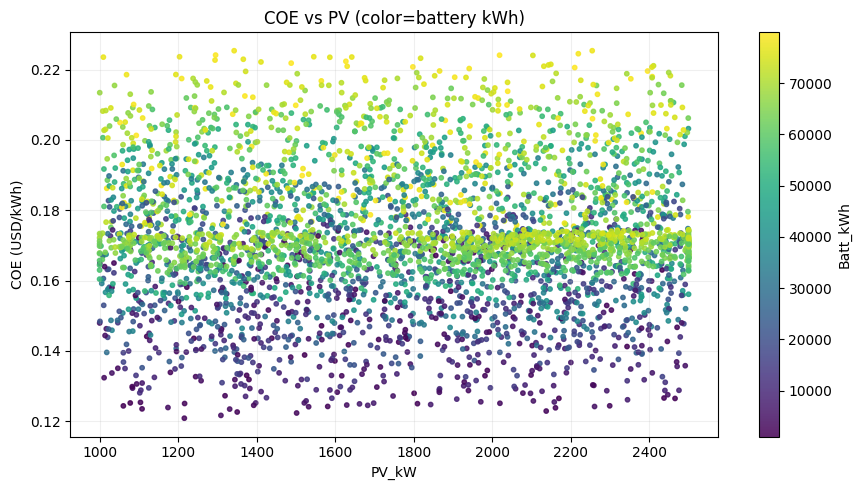

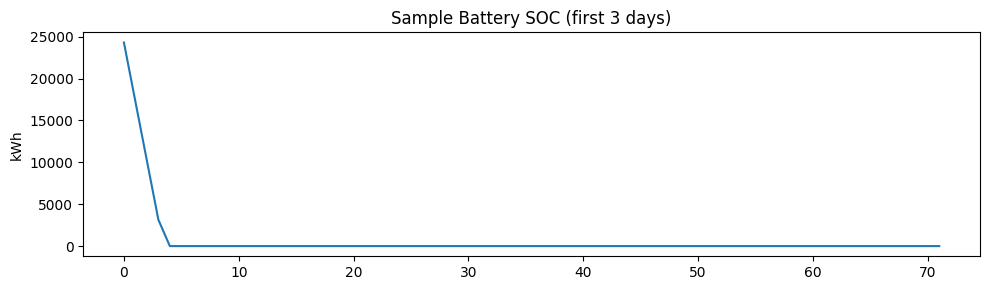

In [ ]:
# Paste & run this cell in Colab/Jupyter (reads IITJodhpur_Sizing_Input.xlsx)
import os, json, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
np.random.seed(42)

# ---------- User config (modified to avoid errors) ----------
INPUT_XL = "/content/drive/MyDrive/B tech project/data/IITJodhpur_Sizing_Input.xlsx"
OUT_DIR = os.path.join(os.path.dirname(INPUT_XL), "/content/drive/MyDrive/B tech project/data/RESULT_campus_hybrid")
os.makedirs(OUT_DIR, exist_ok=True)

# search settings
N_SAMPLES = 3000
REFINE_TOP_K = 80
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Bounds (expanded battery & FC to match campus scale)
PV_EXISTING_KW = 1000.0
PV_KW_BOUNDS = (PV_EXISTING_KW, 2500.0)     # allow up to 2.5 MW PV
FC_MIN_KW = 500.0
FC_KW_BOUNDS = (FC_MIN_KW, 2000.0)          # allow FC up to 2 MW
BATT_KWH_BOUNDS = (1000.0, 80000.0)         # 1 MWh to 80 MWh

# economics (fallback)
PV_CAPEX = 500.0
FC_CAPEX = 1000.0
BATT_CAPEX = 300.0
IMPORT_USD = 0.10
EXPORT_USD = 0.033
INR_TO_USD = 83.0

# battery & system params
PROJECT_YEARS = 20
DISCOUNT_RATE = 0.08
BATT_EFF = 0.92
BATT_POWER_PER_KWH = 1.0

# autonomy & fuel assumptions
AUTONOMY_HOURS = 8                # keep 8h autonomy (change if desired)
FUEL_OP_EX_USD_per_kWh = 0.35     # fuel operating cost estimate
FC_PENALTY_PER_KW_COE = 0.0       # set >0 to discourage large FC

# ---------- helpers ----------
def crf(rate,n):
    if rate==0: return 1.0/n
    return (rate*(1+rate)**n)/((1+rate)**n - 1)

def annualize(capex, rate=DISCOUNT_RATE, life=PROJECT_YEARS):
    return capex * crf(rate, life)

def safe_float(x, fallback):
    try:
        if x is None: return fallback
        if isinstance(x,float) and math.isnan(x): return fallback
        return float(x)
    except:
        return fallback

# ---------- read workbook & aggregate campus load ----------
if not os.path.exists(INPUT_XL):
    raise FileNotFoundError("Workbook not found: " + INPUT_XL)

xl = pd.ExcelFile(INPUT_XL)
if "Department_Hourly" not in xl.sheet_names:
    raise RuntimeError("Workbook must contain 'Department_Hourly' sheet.")

dept_hourly = pd.read_excel(INPUT_XL, sheet_name="Department_Hourly")

if 'Timestamp' not in dept_hourly.columns:
    dept_hourly = dept_hourly.rename(columns={dept_hourly.columns[0]:'Timestamp'})

dept_hourly['Timestamp'] = pd.to_datetime(dept_hourly['Timestamp'])
load_cols = [c for c in dept_hourly.columns if c!='Timestamp']
campus_load_kW = dept_hourly[load_cols].sum(axis=1).fillna(0).values

T = len(campus_load_kW)
hours = np.arange(T) % 24
avg_site_load_kW = campus_load_kW.mean()
night_mask = ((dept_hourly['Timestamp'].dt.hour >= 20) | (dept_hourly['Timestamp'].dt.hour < 6))
avg_night_load_kW = campus_load_kW[night_mask.values].mean() if night_mask.sum()>0 else avg_site_load_kW

# PV template -> Generation_Hourly if present, else sinusoid
pv_template = None
if "Generation_Hourly" in xl.sheet_names:
    gen = pd.read_excel(INPUT_XL, sheet_name="Generation_Hourly")
    pv_col = next((c for c in gen.columns if 'PV' in c or 'pv' in c), None)
    if pv_col:
        pv_arr = pd.to_numeric(gen[pv_col].fillna(0)).values
        pv_template = np.interp(np.linspace(0,len(pv_arr)-1,T), np.arange(len(pv_arr)), pv_arr)
        if pv_template.max()>0:
            pv_template = pv_template / pv_template.max()

if pv_template is None:
    pv_template = np.clip(np.sin((hours - 6)/24.0*2*np.pi), 0, None)
    pv_template = pv_template / (pv_template.max()+1e-12)

wind_template = np.zeros_like(pv_template)

# read cost/tariff overrides
pv_capex = PV_CAPEX; fc_capex = FC_CAPEX; batt_capex = BATT_CAPEX
tariff_import = IMPORT_USD; tariff_export = EXPORT_USD

if "Cost_Data" in xl.sheet_names:
    cd = pd.read_excel(INPUT_XL, sheet_name="Cost_Data")
    for _, r in cd.iterrows():
        p = str(r.get("Parameter","")).lower()
        v = r.get("Value", np.nan)
        units = str(r.get("Units","")).lower()
        if 'pv' in p and 'cap' in p:
            pv_capex = safe_float(v, pv_capex)
        if ('fuel' in p or 'cell' in p) and 'cap' in p:
            fc_capex = safe_float(v, fc_capex)
        if ('batt' in p or 'battery' in p) and ('cap' in p or 'energy' in p):
            batt_capex = safe_float(v, batt_capex)
        if ('grid' in p and 'tariff' in p) or ('tariff' in p and 'grid' in p):
            tval = safe_float(v, np.nan)
            if not math.isnan(tval):
                if 'rs' in units or 'inr' in units:
                    tariff_import = tval / INR_TO_USD
                else:
                    tariff_import = tval
                tariff_export = tariff_import/3.0


print("""Algorithm outline:
        1. Sample initial designs uniformly within bounds.
        2. Simulate each design → compute COE.
        3. Train Random Forest surrogate on (design, COE).
        4. Around the top K designs, sample more points.
        5. Use surrogate to rank new points.
        6. Re-simulate best candidates.
        7. Select global minimum COE. """)



print("Hourly points:", T)
print("Average site load (kW):", round(avg_site_load_kW,2))
print("Avg night load (kW):", round(avg_night_load_kW,2))
print("Autonomy hours:", AUTONOMY_HOURS, "=> battery >= {:.1f} kWh".format(AUTONOMY_HOURS * avg_night_load_kW))
print("Costs (PV,FC,BATT):", pv_capex, fc_capex, batt_capex)
print("Tariff import/export (USD/kWh):", tariff_import, tariff_export)

# ---------- EMS: FC-before-battery ----------
PV_LOW_THRESHOLD = 0.10

def run_campus_ems(load_kW, pv_t, pv_kw, fc_kw, batt_kwh, batt_power_kw=None):
    T = len(load_kW)
    if batt_power_kw is None:
        batt_power_kw = max(0.01, batt_kwh * BATT_POWER_PER_KWH)
    soc = 0.5 * batt_kwh
    pv_gen = pv_t * pv_kw
    imp = np.zeros(T); exp = np.zeros(T); dumped = np.zeros(T); served = np.zeros(T)
    soc_trace = np.zeros(T)

    for t in range(T):
        gen_pv = float(pv_gen[t])
        load = float(load_kW[t])

        if gen_pv >= load:
            served[t] = load
            surplus = gen_pv - load
            ch = min(batt_power_kw, surplus, max(0.0, batt_kwh - soc))
            soc = min(batt_kwh, soc + ch * BATT_EFF)
            remaining = surplus - ch
            exp[t] = remaining
        else:
            after_pv = load - gen_pv
            fc_take = min(fc_kw, after_pv) if fc_kw>0 else 0.0
            after_fc = after_pv - fc_take
            ds = min(batt_power_kw, soc, after_fc)
            soc = max(0.0, soc - ds / (BATT_EFF if BATT_EFF>0 else 1.0))
            after_batt = after_fc - ds
            imp[t] = max(0.0, after_batt)
            served[t] = gen_pv + fc_take + ds + imp[t]

        soc_trace[t] = soc

    # estimate fc_gen_kWh as hours where PV low times fc capacity (conservative estimate)
    fc_hours = float((pv_t < PV_LOW_THRESHOLD).sum())
    fc_gen_kWh = fc_hours * fc_kw if fc_kw is not None else 0.0

    return {
        "import_kWh": float(imp.sum()), "export_kWh": float(exp.sum()), "dumped_kWh": float(dumped.sum()),
        "served_load_kWh": float(served.sum()), "pv_gen_kWh": float(pv_gen.sum()), "fc_gen_kWh": float(fc_gen_kWh),
        "soc_trace": soc_trace
    }

# ---------- evaluator ----------
def evaluate_candidate(load_kW, pv_t, pv_kw, fc_kw, batt_kwh):
    rpt = run_campus_ems(load_kW, pv_t, pv_kw, fc_kw, batt_kwh)
    annual_load = float(np.nansum(load_kW))

    capex_pv = pv_kw * pv_capex
    capex_fc = fc_kw * fc_capex
    capex_batt = batt_kwh * batt_capex
    ann_capex = annualize(capex_pv + capex_fc + capex_batt)
    annual_om = 0.02 * (capex_pv + capex_fc + capex_batt)

    grid_cost = rpt['import_kWh'] * tariff_import - rpt['export_kWh'] * tariff_export
    fuel_cost = rpt['fc_gen_kWh'] * FUEL_OP_EX_USD_per_kWh
    annual_cost = ann_capex + annual_om + grid_cost + fuel_cost

    coe = annual_cost / max(annual_load, 1e-6)
    penalty = FC_PENALTY_PER_KW_COE * max(0.0, fc_kw - FC_MIN_KW) if 'FC_PENALTY_PER_KW_COE' in globals() else 0.0
    coe_penalized = coe + penalty

    return {
        "PV_kW": float(pv_kw), "FC_kW": float(fc_kw), "Batt_kWh": float(batt_kwh),
        "annualized_capex_usd": float(ann_capex), "annual_cost_usd": float(annual_cost),
        "COE_usd_per_kWh": float(coe_penalized),
        "import_kWh": float(rpt['import_kWh']), "export_kWh": float(rpt['export_kWh']),
        "pv_gen_kWh": float(rpt['pv_gen_kWh']), "fc_gen_kWh": float(rpt['fc_gen_kWh']),
        "served_load_kWh": float(rpt['served_load_kWh'])
    }


'''
##  ML-based sizing search with Random Forest surrogate

Exhaustively exploring all combinations of PV, FC and battery sizes is computationally expensive.
Following the machine-learning-based approach of [1], we use a **two-stage search:**

1. **Initial random sampling**
   - Draw `N_SAMPLES` random points in the design space:
     \((P_{\text{PV,cap}}, P_{\text{FC,cap}}, E_{\text{batt}})\).
   - Evaluate each point with the EMS and cost model.
   - Apply an autonomy constraint:
     \[
     E_{\text{batt}} \ge P_\text{night,avg} \times \text{AUTONOMY\_HOURS}
     \]

2. **Surrogate model refinement**
   - Fit a Random Forest Regressor to predict COE from the sampled designs.
   - Select the best `REFINE_TOP_K` designs.
   - Generate refined candidate points around these designs using Gaussian perturbations.
   - Use the surrogate to rank these refined points, then **re-simulate** the most promising ones with the full EMS.

Finally we select the design with the **lowest COE** that satisfies the autonomy requirement.
The function returns:
- `df`: DataFrame of all evaluated candidates.
- `best`: the best-performing configuration.


'''
# ---------- search with robust autonomy filter ----------
def campus_sizing_search(load_kW, pv_t, n_samples=N_SAMPLES):
    samples = [(float(np.random.uniform(*PV_KW_BOUNDS)),
                float(np.random.uniform(*FC_KW_BOUNDS)),
                float(np.random.uniform(*BATT_KWH_BOUNDS))) for _ in range(n_samples)]

    recs = []
    for pv, fc, batt in samples:
        recs.append(evaluate_candidate(load_kW, pv_t, pv, fc, batt))

    df = pd.DataFrame(recs).dropna(subset=['COE_usd_per_kWh']).reset_index(drop=True)

    # autonomy threshold
    min_batt_needed = AUTONOMY_HOURS * avg_night_load_kW

    # first try strict filter, then relax if too few candidates
    df_filtered = df[df['Batt_kWh'] >= min_batt_needed].copy()
    if df_filtered.shape[0] < max(30, int(0.02 * len(df))):
        relaxed = max(0.9 * min_batt_needed, min_batt_needed - 0.1*min_batt_needed)
        df_filtered = df[df['Batt_kWh'] >= relaxed].copy()

    if df_filtered.empty:
        # final fallback: warn and continue with full df
        print("Warning: Autonomy filter removed all candidates. Relaxing filter and continuing with all candidates.")
        df_filtered = df.copy()

    # ensure required columns exist
    required = ['PV_kW','FC_kW','Batt_kWh','COE_usd_per_kWh']
    for col in required:
        if col not in df_filtered.columns:
            raise RuntimeError(f"Missing expected column '{col}' in candidate DataFrame.")

    # surrogate training
    X = df_filtered[['PV_kW','FC_kW','Batt_kWh']].astype(float)
    y = df_filtered['COE_usd_per_kWh'].astype(float)
    rf = RandomForestRegressor(n_estimators=180, random_state=RANDOM_SEED)
    rf.fit(X, y)

    # refine around top performers (use key access, not attribute)
    top = df_filtered.nsmallest(REFINE_TOP_K, 'COE_usd_per_kWh')
    refined = []
    for _, row in top.iterrows():
        center = np.array([float(row['PV_kW']), float(row['FC_kW']), float(row['Batt_kWh'])])
        for _ in range(max(20, 250 // max(1, REFINE_TOP_K))):
            cand = center + np.random.normal(
                scale=[max(10,center[0]*0.08), max(5,center[1]*0.08), max(50,center[2]*0.08)]
            )
            cand = np.clip(
                cand,
                [PV_KW_BOUNDS[0], FC_KW_BOUNDS[0], BATT_KWH_BOUNDS[0]],
                [PV_KW_BOUNDS[1], FC_KW_BOUNDS[1], BATT_KWH_BOUNDS[1]]
            )
            refined.append(cand)

    refined = np.unique(np.round(np.array(refined),3), axis=0) if len(refined)>0 else np.empty((0,3))

    if refined.shape[0] > 0:
        try:
            preds = rf.predict(refined)
        except Exception as e:
            print("Surrogate predict failed:", e)
            preds = np.zeros(len(refined))

        cand_df = pd.DataFrame(refined, columns=['PV_kW','FC_kW','Batt_kWh'])
        cand_df['pred_coe'] = preds
        shortlist = cand_df.nsmallest(min(800, len(cand_df)), 'pred_coe')

        for _, r in shortlist.iterrows():
            pv_c = float(r['PV_kW'])
            # *** FIXED: use 'FC_kW' (lowercase k) instead of 'FC_KW' ***
            fc_c = float(r['FC_kW'])
            batt_c = float(r['Batt_kWh'])
            rec = evaluate_candidate(load_kW, pv_t, pv_c, fc_c, batt_c)
            df = pd.concat([df, pd.DataFrame([rec])], ignore_index=True)

    # choose best among those meeting original min_batt (if any), otherwise global best
    df_valid = df[df['Batt_kWh'] >= min_batt_needed].copy()
    if df_valid.empty:
        df_valid = df.copy()

    best_row = df_valid.nsmallest(1, 'COE_usd_per_kWh').iloc[0]
    best = best_row.to_dict()
    return df, best

# ---------- run ----------
print("Running campus sizing with AUTONOMY_HOURS =", AUTONOMY_HOURS)
df_all, best = campus_sizing_search(campus_load_kW, pv_template, n_samples=N_SAMPLES)

# save results
df_all.to_csv(os.path.join(OUT_DIR,"campus_candidates_v2.csv"), index=False)
with open(os.path.join(OUT_DIR,"best_campus_config_v2.json"), "w") as f:
    json.dump(best, f, indent=2)

# summary print
print("\n=== BEST CAMPUS CONFIG ===")
print("PV_kW   : %.1f kW" % best['PV_kW'])
print("FC_kW   : %.1f kW" % best['FC_kW'])
print("Batt_kWh: %.1f kWh" % best['Batt_kWh'])
print("COE ($/kWh): %.4f" % best['COE_usd_per_kWh'])
print("Annual import kWh (est): %.1f" % best.get('import_kWh',0.0))
print("Saved results to:", OUT_DIR)

# quick visual
plt.figure(figsize=(9,5))
plt.scatter(df_all['PV_kW'], df_all['COE_usd_per_kWh'], c=df_all['Batt_kWh'], s=10, cmap='viridis', alpha=0.85)
plt.colorbar(label='Batt_kWh')
plt.xlabel('PV_kW'); plt.ylabel('COE (USD/kWh)')
plt.title('COE vs PV (color=battery kWh)')
plt.grid(alpha=0.2); plt.tight_layout(); plt.show()

# sample SOC plot for best
best_trace = run_campus_ems(campus_load_kW, pv_template, best['PV_kW'], best['FC_kW'], best['Batt_kWh'])
soc = best_trace['soc_trace']
plt.figure(figsize=(10,3))
plt.plot(soc[:24*3])
plt.title('Sample Battery SOC (first 3 days)')
plt.ylabel('kWh')
plt.tight_layout()
plt.show()


## . Design space visualization: COE vs PV size

To understand the trade-offs between design choices and cost, this plot shows:

- **X-axis:** PV capacity (kW)
- **Y-axis:** COE (USD/kWh)
- **Color:** Battery energy capacity (kWh)

This scatter plot helps us visually inspect:

- How increasing PV size affects COE.
- The role of battery size (color gradient).
- Whether there are clusters of low-cost solutions.

Such plots play a similar role to the parametric studies shown in [1].


In [ ]:
print("""## 11. Battery state of charge (SOC) for the best design

Finally, we visualize the **battery SOC trajectory** for the optimal configuration over the first few days of the year.

- This time series shows how the battery charges during sunny periods and discharges during high load or low-PV periods.
- It helps verify that the autonomy requirement is being met (the battery is large enough to cover night-time demand for the specified number of hours).

For publication or a report, you may later zoom into representative weeks (summer / winter) to illustrate seasonal differences, similar to the illustrative SOC plots often shown in hybrid system studies like [1].
""")

## 11. Battery state of charge (SOC) for the best design

Finally, we visualize the **battery SOC trajectory** for the optimal configuration over the first few days of the year.

- This time series shows how the battery charges during sunny periods and discharges during high load or low-PV periods.
- It helps verify that the autonomy requirement is being met (the battery is large enough to cover night-time demand for the specified number of hours).

For publication or a report, you may later zoom into representative weeks (summer / winter) to illustrate seasonal differences, similar to the illustrative SOC plots often shown in hybrid system studies like [1].



#Why we Go for the Hybrid model BATT. , FUEL CELL , PV





In [ ]:
# ===== IITJodhpur sizing with Fuel Cell + PV + Battery (no wind) =====
import os, json, math
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor

# ---------------- USER CONFIG ----------------
INPUT_XL = "/content/drive/MyDrive/B tech project/data/IITJodhpur_Sizing_Input.xlsx"   # set this to your workbook path if different
OUT_DIR = os.path.join(os.path.dirname(INPUT_XL), "/content/drive/MyDrive/B tech project/data/RESULT BATT. FUEL CELL PV")
os.makedirs(OUT_DIR, exist_ok=True)

# sampling / search (reduce for quick tests)
N_SAMPLES = 800        # increase for final runs
REFINE_TOP_K = 60
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# ------------------------------------------------------------------
# Bounds tuned to your approximate campus numbers:
#   PV ~ 1 MW, Fuel Cell ~ 500 kW, Battery ~ 2 MWh (2000 kWh)
# ------------------------------------------------------------------
PV_KW_BOUNDS = (0.0, 1200.0)     # up to 1.2 MW PV
FC_KW_BOUNDS = (0.0, 600.0)      # fuel cell up to 600 kW (center ~500)
BATT_KWH_BOUNDS = (0.0, 3000.0)  # battery energy up to 3 MWh

# default economics (fallback)
DEFAULT_PV_CAPEX = 500.0
DEFAULT_FC_CAPEX = 1000.0    # fuel cell CAPEX (USD/kW) — adjust to your source
DEFAULT_BATT_CAPEX = 300.0
DEFAULT_IMPORT_USD = 0.10
DEFAULT_EXPORT_USD = 0.033
INR_TO_USD = 83.0

# battery & system
PROJECT_YEARS = 20
DISCOUNT_RATE = 0.08
BATT_CH_DIS_POWER_PER_KWH = 1.0
BATT_EFF = 0.92

# ---------------- helpers ----------------
def crf(rate, n):
    if rate == 0: return 1.0/n
    return (rate*(1+rate)**n)/((1+rate)**n - 1)
def annualize(capex, rate=DISCOUNT_RATE, life=PROJECT_YEARS):
    return capex * crf(rate, life)
def safe_float(x, fallback):
    try:
        if x is None: return fallback
        if isinstance(x, float) and math.isnan(x): return fallback
        return float(x)
    except Exception:
        return fallback

# ---------------- read workbook ----------------
def read_workbook(xl_path):
    if not os.path.exists(xl_path):
        raise FileNotFoundError(f"Workbook not found: {xl_path}")
    xl = pd.ExcelFile(xl_path)
    wb = {}
    for sheet in xl.sheet_names:
        try:
            wb[sheet] = pd.read_excel(xl_path, sheet_name=sheet)
        except Exception as e:
            print(f"Warning reading sheet {sheet}: {e}")
    return wb

# ---------------- templates ----------------
def build_generation_templates(wb, length):
    # PV template if Generation_Hourly exists, else diurnal; wind is zero (no wind)
    if 'Generation_Hourly' in wb:
        gen = wb['Generation_Hourly']
        # find PV column
        pv_col = next((c for c in gen.columns if 'PV' in c and 'Base' in c), None)
        if pv_col is not None:
            pv_arr = pd.to_numeric(gen[pv_col].fillna(0)).values
            pv_template = np.interp(np.linspace(0, len(pv_arr)-1, length), np.arange(len(pv_arr)), pv_arr)
            pv_template = pv_template / (pv_template.max()+1e-12)
        else:
            hours = np.arange(length) % 24
            pv_template = np.clip(np.sin((hours - 6)/24.0*2*np.pi), 0, None)
            pv_template = pv_template/(pv_template.max()+1e-12)
    else:
        hours = np.arange(length) % 24
        pv_template = np.clip(np.sin((hours - 6)/24.0*2*np.pi), 0, None)
        pv_template = pv_template/(pv_template.max()+1e-12)
    wind_template = np.zeros(length)  # no wind in this run
    return pv_template, wind_template

# ---------------- EMS: now includes fuel cell ----------------
def run_ems_with_fc(load_kW, pv_t, wind_t, pv_kw, fc_kw, batt_kwh,
                    batt_power_kw=None, import_limit_kw=1e9, export_limit_kw=1e9):
    T = len(load_kW)
    if batt_power_kw is None:
        batt_power_kw = max(0.01, batt_kwh * BATT_CH_DIS_POWER_PER_KWH)
    soc = 0.5 * batt_kwh
    pv_gen = pv_t * pv_kw
    wind_gen = wind_t * 0.0  # zero
    fc_gen = np.ones(T) * fc_kw   # dispatchable (can produce up to fc_kw every hour)

    imp = np.zeros(T)
    exp = np.zeros(T)
    dumped = np.zeros(T)
    served = np.zeros(T)
    soc_trace = np.zeros(T)

    for t in range(T):
        gen = float(pv_gen[t]) + float(wind_gen[t])
        load = float(load_kW[t])

        # First use PV (and small wind if present)
        if gen >= load:
            served[t] = load
            surplus = gen - load
            # charge battery from PV surplus (limited by batt power & remaining energy)
            ch = min(batt_power_kw, surplus, max(0.0, batt_kwh - soc))
            soc += ch * BATT_EFF
            remaining = surplus - ch
            # we do not run fuel cell in export-only scenario (fuel cell used when needed)
            exp[t] = min(remaining, export_limit_kw)
            dumped[t] = max(0.0, remaining - exp[t])
        else:
            # PV insufficient: use fuel cell next (dispatchable, cheaper than importing if fuel cell assumed)
            after_pv = load - gen
            fc_provide = min(fc_kw, after_pv)
            after_fc = after_pv - fc_provide
            # then battery discharge
            ds = min(batt_power_kw, soc, after_fc)
            soc -= ds / (BATT_EFF if BATT_EFF>0 else 1.0)
            after_batt = after_fc - ds
            # remaining -> import from grid
            imp[t] = min(after_batt, import_limit_kw)
            served[t] = gen + fc_provide + ds + imp[t]
            # if after_batt > imp[t], assume grid supplies rest (count as import)
            if after_batt > imp[t]:
                imp[t] += (after_batt - imp[t])
                served[t] += (after_batt - imp[t])
        soc_trace[t] = soc

    return {
        "import_kWh": float(imp.sum()),
        "export_kWh": float(exp.sum()),
        "dumped_kWh": float(dumped.sum()),
        "served_load_kWh": float(served.sum()),
        "pv_gen_kWh": float(pv_gen.sum()),
        "fc_gen_kWh": float(fc_gen.sum()),
        "wind_gen_kWh": float(0.0),
        "soc_trace": soc_trace
    }

# ---------------- cost & eval ----------------
def evaluate_candidate_fc(load_kW, pv_t, wind_t, pv_kw, fc_kw, batt_kwh, cost_params, tariff_import, tariff_export):
    rpt = run_ems_with_fc(load_kW, pv_t, wind_t, pv_kw, fc_kw, batt_kwh)
    annual_load = float(np.nansum(load_kW))
    capex_pv = pv_kw * cost_params['pv_capex_usd_per_kw']
    capex_fc = fc_kw * cost_params['fc_capex_usd_per_kw']
    capex_batt = batt_kwh * cost_params['batt_capex_usd_per_kwh']
    ann_capex = annualize(capex_pv + capex_fc + capex_batt)
    annual_om = 0.02 * (capex_pv + capex_fc + capex_batt)
    grid_cost = rpt['import_kWh'] * tariff_import - rpt['export_kWh'] * tariff_export
    annual_cost = ann_capex + annual_om + grid_cost
    coe = annual_cost / max(annual_load, 1e-6)
    return {
        "PV_kW": float(pv_kw),
        "FC_kW": float(fc_kw),
        "Batt_kWh": float(batt_kwh),
        "annualized_capex_usd": float(ann_capex),
        "annual_cost_usd": float(annual_cost),
        "COE_usd_per_kWh": float(coe),
        "import_kWh": float(rpt['import_kWh']),
        "export_kWh": float(rpt['export_kWh']),
        "pv_gen_kWh": float(rpt['pv_gen_kWh']),
        "fc_gen_kWh": float(rpt['fc_gen_kWh']),
        "served_load_kWh": float(rpt['served_load_kWh'])
    }

# ---------------- search pipeline (PV, FC, Batt) ----------------
def sizing_pipeline_fc(load_series_kW, pv_t, wind_t, cost_params, tariff_import, tariff_export, n_samples=N_SAMPLES):
    samples = [(float(np.random.uniform(*PV_KW_BOUNDS)),
                float(np.random.uniform(*FC_KW_BOUNDS)),
                float(np.random.uniform(*BATT_KWH_BOUNDS))) for _ in range(n_samples)]
    records = []
    for pv, fc, batt in samples:
        records.append(evaluate_candidate_fc(load_series_kW, pv_t, wind_t, pv, fc, batt, cost_params, tariff_import, tariff_export))
    df = pd.DataFrame(records)
    df_clean = df.dropna(subset=['COE_usd_per_kWh','PV_kW','FC_kW','Batt_kWh']).copy()
    if df_clean.shape[0] < 20:
        best = df_clean.nsmallest(1, 'COE_usd_per_kWh').iloc[0].to_dict() if df_clean.shape[0]>0 else {}
        return df_clean, best
    X = df_clean[['PV_kW','FC_kW','Batt_kWh']].astype(float)
    y = df_clean['COE_usd_per_kWh'].astype(float)
    rf = RandomForestRegressor(n_estimators=150, random_state=RANDOM_SEED)
    rf.fit(X, y)
    top = df_clean.nsmallest(REFINE_TOP_K, 'COE_usd_per_kWh')
    refined = []
    for _, r in top.iterrows():
        center = np.array([r.PV_kW, r.FC_kW, r.Batt_kWh])
        for _ in range(200):
            cand = center + np.random.normal(scale=[max(5,center[0]*0.12), max(5,center[1]*0.12), max(20,center[2]*0.12)])
            cand = np.clip(cand, [PV_KW_BOUNDS[0], FC_KW_BOUNDS[0], BATT_KWH_BOUNDS[0]],
                                 [PV_KW_BOUNDS[1], FC_KW_BOUNDS[1], BATT_KWH_BOUNDS[1]])
            refined.append(cand)
    refined = np.unique(np.round(refined,3), axis=0)
    if len(refined)==0:
        best = df_clean.nsmallest(1,'COE_usd_per_kWh').iloc[0].to_dict()
        return df_clean, best
    preds = rf.predict(refined)
    cand_df = pd.DataFrame(refined, columns=['PV_kW','FC_kW','Batt_kWh'])
    cand_df['pred_coe'] = preds
    shortlist = cand_df.nsmallest(300, 'pred_coe')
    for _, r in shortlist.iterrows():
        rec = evaluate_candidate_fc(load_series_kW, pv_t, wind_t, r.PV_kW, r.FC_kW, r.Batt_kWh, cost_params, tariff_import, tariff_export)
        df = pd.concat([df, pd.DataFrame([rec])], ignore_index=True)
    best = df.nsmallest(1, 'COE_usd_per_kWh').iloc[0].to_dict()
    return df, best

# ---------------- top-level ----------------
def run_fc_from_workbook(input_xl=INPUT_XL, out_dir=OUT_DIR, n_samples=N_SAMPLES):
    wb = read_workbook(input_xl)
    # cost params (include fuel cell)
    cost_params = {
        'pv_capex_usd_per_kw': DEFAULT_PV_CAPEX,
        'fc_capex_usd_per_kw': DEFAULT_FC_CAPEX,
        'batt_capex_usd_per_kwh': DEFAULT_BATT_CAPEX
    }
    tariff_import = DEFAULT_IMPORT_USD
    tariff_export = DEFAULT_EXPORT_USD
    # override from cost_data sheet if present
    if 'Cost_Data' in wb:
        cd = wb['Cost_Data']
        for _, row in cd.iterrows():
            p = str(row.get('Parameter','')).lower()
            v = row.get('Value', np.nan)
            units = str(row.get('Units','')).lower()
            if 'pv' in p and 'cap' in p:
                cost_params['pv_capex_usd_per_kw'] = safe_float(v, cost_params['pv_capex_usd_per_kw'])
            if 'fuel' in p or 'cell' in p:
                cost_params['fc_capex_usd_per_kw'] = safe_float(v, cost_params['fc_capex_usd_per_kw'])
            if ('batt' in p or 'battery' in p) and ('cap' in p or 'energy' in p):
                cost_params['batt_capex_usd_per_kwh'] = safe_float(v, cost_params['batt_capex_usd_per_kwh'])
            if 'tariff' in p and ('grid' in p or 'import' in p):
                tval = safe_float(v, np.nan)
                if not math.isnan(tval):
                    if 'rs' in units or 'inr' in units:
                        tariff_import = tval / INR_TO_USD
                    else:
                        tariff_import = tval
                    tariff_export = tariff_import/3.0

    # department hourly table required
    if 'Department_Hourly' not in wb:
        raise RuntimeError("Workbook must contain 'Department_Hourly' sheet.")
    dept_hourly = wb['Department_Hourly'].copy()
    if 'Timestamp' not in dept_hourly.columns:
        dept_hourly = dept_hourly.rename(columns={dept_hourly.columns[0]:'Timestamp'})
    dept_hourly['Timestamp'] = pd.to_datetime(dept_hourly['Timestamp'])
    building_cols = [c for c in dept_hourly.columns if c!='Timestamp']
    L = len(dept_hourly)
    pv_t, wind_t = build_generation_templates(wb, L)
    results = {}
    all_cands = []
    for b in building_cols:
        print("Processing:", b)
        load_series = pd.to_numeric(dept_hourly[b].fillna(0)).values
        df_cand, best = sizing_pipeline_fc(load_series, pv_t, wind_t, cost_params, tariff_import, tariff_export, n_samples=n_samples)
        out_csv = os.path.join(out_dir, f"{b}_fc_sizing_candidates.csv")
        df_cand.to_csv(out_csv, index=False)
        print(" saved:", out_csv)
        results[b] = best
        tmp = df_cand.copy(); tmp['Building']=b; all_cands.append(tmp)
    if all_cands:
        pd.concat(all_cands, ignore_index=True).to_csv(os.path.join(out_dir,"all_buildings_fc_candidates.csv"), index=False)
    with open(os.path.join(out_dir,"best_per_building_fc.json"), "w") as f:
        json.dump(results, f, indent=2)
    print("Finished. Results in:", out_dir)
    return results

# run
if __name__ == "__main__":
    summary = run_fc_from_workbook()


Processing: Admin Building East


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


 saved: /content/drive/MyDrive/B tech project/data/RESULT BATT. FUEL CELL PV/Admin Building East_fc_sizing_candidates.csv
Processing: Admin Building West


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


 saved: /content/drive/MyDrive/B tech project/data/RESULT BATT. FUEL CELL PV/Admin Building West_fc_sizing_candidates.csv
Processing: BERM (E-1 to E-8)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


 saved: /content/drive/MyDrive/B tech project/data/RESULT BATT. FUEL CELL PV/BERM (E-1 to E-8)_fc_sizing_candidates.csv
Processing: Basic Department


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


 saved: /content/drive/MyDrive/B tech project/data/RESULT BATT. FUEL CELL PV/Basic Department_fc_sizing_candidates.csv
Processing: Bioscience Department


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


 saved: /content/drive/MyDrive/B tech project/data/RESULT BATT. FUEL CELL PV/Bioscience Department_fc_sizing_candidates.csv
Processing: C.S.E.


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


 saved: /content/drive/MyDrive/B tech project/data/RESULT BATT. FUEL CELL PV/C.S.E._fc_sizing_candidates.csv
Processing: Chemistry


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


 saved: /content/drive/MyDrive/B tech project/data/RESULT BATT. FUEL CELL PV/Chemistry_fc_sizing_candidates.csv
Processing: Computer Center


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


 saved: /content/drive/MyDrive/B tech project/data/RESULT BATT. FUEL CELL PV/Computer Center_fc_sizing_candidates.csv
Processing: Electrical Department


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


 saved: /content/drive/MyDrive/B tech project/data/RESULT BATT. FUEL CELL PV/Electrical Department_fc_sizing_candidates.csv
Processing: Instrumentation


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


 saved: /content/drive/MyDrive/B tech project/data/RESULT BATT. FUEL CELL PV/Instrumentation_fc_sizing_candidates.csv
Processing: KV School


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


 saved: /content/drive/MyDrive/B tech project/data/RESULT BATT. FUEL CELL PV/KV School_fc_sizing_candidates.csv
Processing: L.H.B.


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


 saved: /content/drive/MyDrive/B tech project/data/RESULT BATT. FUEL CELL PV/L.H.B._fc_sizing_candidates.csv
Processing: Libraray


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


 saved: /content/drive/MyDrive/B tech project/data/RESULT BATT. FUEL CELL PV/Libraray_fc_sizing_candidates.csv
Processing: Mechanical Department


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


 saved: /content/drive/MyDrive/B tech project/data/RESULT BATT. FUEL CELL PV/Mechanical Department_fc_sizing_candidates.csv
Processing: Workshop Civil Department


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


 saved: /content/drive/MyDrive/B tech project/data/RESULT BATT. FUEL CELL PV/Workshop Civil Department_fc_sizing_candidates.csv
Processing: nan


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


 saved: /content/drive/MyDrive/B tech project/data/RESULT BATT. FUEL CELL PV/nan_fc_sizing_candidates.csv
Finished. Results in: /content/drive/MyDrive/B tech project/data/RESULT BATT. FUEL CELL PV


Saved: /content/drive/MyDrive/B tech project/data/RESULT BATT. FUEL CELL PV/campus_total_requirements.csv
Saved: /content/drive/MyDrive/B tech project/data/RESULT BATT. FUEL CELL PV/campus_total_requirements.json
Campus totals:
  PV  total: 898.4 kW
  FC  total: 4332.4 kW
  Batt total: 1217.2 kWh


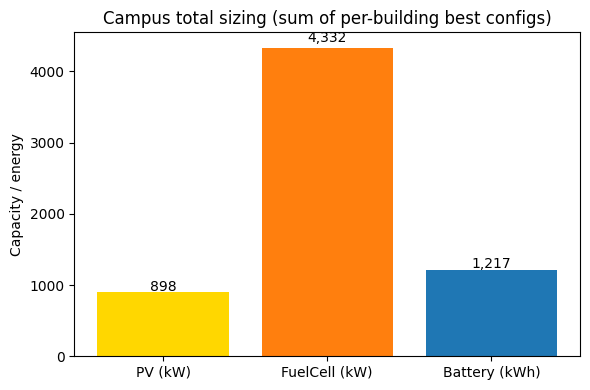

Saved plot: /content/drive/MyDrive/B tech project/data/RESULT BATT. FUEL CELL PV/campus_totals_bar.png


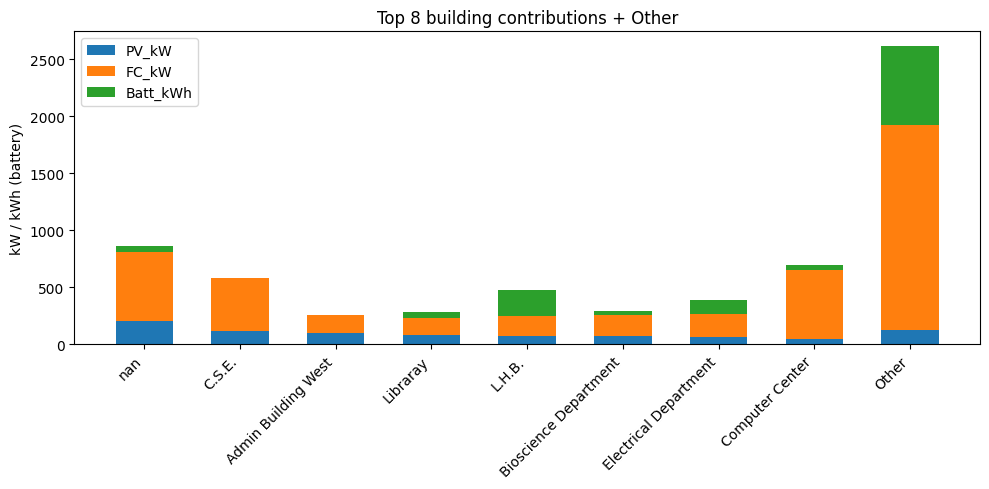

Saved plot: /content/drive/MyDrive/B tech project/data/RESULT BATT. FUEL CELL PV/campus_stacked_top_buildings.png

Top 10 buildings (by PV_kW):


,Building,PV_kW,FC_kW,Batt_kWh,COE_usd_per_kWh
0,nan,208.740,600.000,50.592,0.088759
1,C.S.E.,114.348,468.334,0.000,0.024612
2,Admin Building West,98.451,157.026,0.000,0.041020
3,Libraray,84.358,145.549,50.811,0.031119
4,L.H.B.,75.094,172.260,229.333,0.033719
5,Bioscience Department,72.059,189.629,34.007,0.028400
6,Electrical Department,67.555,200.639,122.049,0.030458
7,Computer Center,49.935,600.000,42.996,0.056055
8,Workshop Civil Department,41.343,67.815,10.202,0.165072
9,Mechanical Department,24.729,283.478,86.419,0.023570


In [ ]:
# Aggregate and plot campus sizing from FC+PV+BESS results
import os, json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === USER: set this to your results folder ===
RESULT_DIR = "/content/drive/MyDrive/B tech project/data/RESULT BATT. FUEL CELL PV"

# === outputs ===
OUT_SUM_CSV = os.path.join(RESULT_DIR, "campus_total_requirements.csv")
OUT_SUM_JSON = os.path.join(RESULT_DIR, "campus_total_requirements.json")
OUT_PLOT1 = os.path.join(RESULT_DIR, "campus_totals_bar.png")
OUT_PLOT2 = os.path.join(RESULT_DIR, "campus_stacked_top_buildings.png")

# === load best-per-building if available ===
best_json = os.path.join(RESULT_DIR, "best_per_building_fc.json")
per_building = {}

if os.path.exists(best_json):
    with open(best_json, "r") as f:
        per_building = json.load(f)
    # ensure numeric conversion
    for b, rec in list(per_building.items()):
        try:
            per_building[b] = {
                "PV_kW": float(rec.get("PV_kW", 0.0) or 0.0),
                "FC_kW": float(rec.get("FC_kW", 0.0) or 0.0),
                "Batt_kWh": float(rec.get("Batt_kWh", 0.0) or 0.0),
                "COE_usd_per_kWh": float(rec.get("COE_usd_per_kWh", np.nan))
            }
        except Exception:
            per_building[b] = {"PV_kW":0.0,"FC_kW":0.0,"Batt_kWh":0.0,"COE_usd_per_kWh":np.nan}
else:
    # fallback: scan per-building *_fc_sizing_candidates.csv and pick min COE row
    files = [fn for fn in os.listdir(RESULT_DIR) if fn.endswith("_fc_sizing_candidates.csv")]
    if not files:
        raise FileNotFoundError(f"No best_per_building_fc.json or *_fc_sizing_candidates.csv found in {RESULT_DIR}")
    for fn in files:
        path = os.path.join(RESULT_DIR, fn)
        bname = fn.replace("_fc_sizing_candidates.csv", "")
        df = pd.read_csv(path)
        if "COE_usd_per_kWh" in df.columns:
            row = df.loc[df["COE_usd_per_kWh"].idxmin()]
        else:
            row = df.iloc[0]
        per_building[bname] = {
            "PV_kW": float(row.get("PV_kW", 0.0) or 0.0),
            "FC_kW": float(row.get("FC_kW", 0.0) or 0.0),
            "Batt_kWh": float(row.get("Batt_kWh", 0.0) or 0.0),
            "COE_usd_per_kWh": float(row.get("COE_usd_per_kWh", np.nan))
        }

# === build DataFrame and totals ===
df = pd.DataFrame.from_dict(per_building, orient="index").reset_index().rename(columns={"index":"Building"})
df = df[["Building","PV_kW","FC_kW","Batt_kWh","COE_usd_per_kWh"]]
df = df.sort_values(by="PV_kW", ascending=False).reset_index(drop=True)

totals = {
    "PV_kW_total": df["PV_kW"].sum(),
    "FC_kW_total": df["FC_kW"].sum(),
    "Batt_kWh_total": df["Batt_kWh"].sum()
}

# save summary files
df.to_csv(OUT_SUM_CSV, index=False)
with open(OUT_SUM_JSON, "w") as f:
    json.dump({"totals": totals, "per_building": per_building}, f, indent=2)

print("Saved:", OUT_SUM_CSV)
print("Saved:", OUT_SUM_JSON)
print("Campus totals:")
print(f"  PV  total: {totals['PV_kW_total']:.1f} kW")
print(f"  FC  total: {totals['FC_kW_total']:.1f} kW")
print(f"  Batt total: {totals['Batt_kWh_total']:.1f} kWh")

# === Plot 1: simple bar of totals ===
plt.figure(figsize=(6,4))
labels = ["PV (kW)", "FuelCell (kW)", "Battery (kWh)"]
vals = [totals["PV_kW_total"], totals["FC_kW_total"], totals["Batt_kWh_total"]]
plt.bar(labels, vals, color=["gold","tab:orange","tab:blue"])
plt.ylabel("Capacity / energy")
plt.title("Campus total sizing (sum of per-building best configs)")
for i,v in enumerate(vals):
    plt.text(i, v*1.02, f"{v:,.0f}", ha="center")
plt.tight_layout()
plt.savefig(OUT_PLOT1, dpi=200)
plt.show()
print("Saved plot:", OUT_PLOT1)

# === Plot 2: stacked bar of top-N buildings contributions ===
TOP_N = 8
df_top = df.copy()
df_top['Other'] = ""
if len(df_top) > TOP_N:
    top_df = df_top.head(TOP_N).copy()
    other = df_top.iloc[TOP_N:][["PV_kW","FC_kW","Batt_kWh"]].sum()
    # build stacked bars (PV, FC, Batt) for top_N and 'Other'
    stacked = top_df[["Building","PV_kW","FC_kW","Batt_kWh"]].set_index("Building")
    stacked.loc["Other"] = other
else:
    stacked = df_top[["Building","PV_kW","FC_kW","Batt_kWh"]].set_index("Building")

# stacked plot (PV, FC, Batt) side-by-side grouped by building
fig, ax = plt.subplots(figsize=(10,5))
ind = np.arange(len(stacked.index))
width = 0.6
p1 = ax.bar(ind, stacked["PV_kW"], width, label="PV_kW")
p2 = ax.bar(ind, stacked["FC_kW"], width, bottom=stacked["PV_kW"], label="FC_kW")
p3 = ax.bar(ind, stacked["Batt_kWh"], width, bottom=stacked["PV_kW"]+stacked["FC_kW"], label="Batt_kWh")
ax.set_xticks(ind)
ax.set_xticklabels(stacked.index, rotation=45, ha="right")
ax.set_ylabel("kW / kWh (battery)")
ax.set_title(f"Top {min(TOP_N,len(stacked))} building contributions + Other")
ax.legend()
plt.tight_layout()
plt.savefig(OUT_PLOT2, dpi=200)
plt.show()
print("Saved plot:", OUT_PLOT2)

# === show top 10 building table (printed) ===
print("\nTop 10 buildings (by PV_kW):")
display(df.head(10))


#battery wind solar combination


In [ ]:
# ===== IITJodhpur sizing from workbook only (rule-based EMS + surrogate search) =====
import os, json, math
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor

# ---------------- USER CONFIG ----------------
INPUT_XL = "/content/drive/MyDrive/B tech project/data/IITJodhpur_Sizing_Input.xlsx"   # <--- set path if different
OUT_DIR = os.path.join(os.path.dirname(INPUT_XL), "/content/drive/MyDrive/B tech project/data/RESULT")
os.makedirs(OUT_DIR, exist_ok=True)

# search / simulation settings (start small for quick test)
N_SAMPLES = 600           # increase to 2000-8000 for better accuracy (paper used large samples)
REFINE_TOP_K = 40
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# design bounds (tune as needed)
PV_KW_BOUNDS = (0.0, 200.0)
WIND_KW_BOUNDS = (0.0, 50.0)
BATT_KWH_BOUNDS = (0.0, 500.0)

# default economics (fallback if Cost_Data absent or NaN)
DEFAULT_PV_CAPEX = 500.0
DEFAULT_WIND_CAPEX = 1500.0
DEFAULT_BATT_CAPEX = 300.0
DEFAULT_IMPORT_USD = 0.10
DEFAULT_EXPORT_USD = 0.033
INR_TO_USD = 83.0

# battery & system assumptions
PROJECT_YEARS = 20
DISCOUNT_RATE = 0.08
BATT_CH_DIS_POWER_PER_KWH = 1.0
BATT_EFF = 0.92

# EMS / TOU defaults (from paper)
TOU_PEAK_HOURS = list(range(8,21))   # 08:00-20:00 peak
CRITICAL_HOUR_DEFAULT = 12           # hc in paper (12:00)

# ---------------- helpers ----------------
def crf(rate, n):
    if rate == 0: return 1.0/n
    return (rate*(1+rate)**n)/((1+rate)**n - 1)

def annualize(capex, rate=DISCOUNT_RATE, life=PROJECT_YEARS):
    return capex * crf(rate, life)

def safe_float(x, fallback):
    try:
        if x is None: return fallback
        if isinstance(x, float) and math.isnan(x): return fallback
        return float(x)
    except Exception:
        return fallback

# ---------------- read workbook (ONLY) ----------------
def read_workbook(xl_path):
    if not os.path.exists(xl_path):
        raise FileNotFoundError(f"Workbook not found: {xl_path}")
    xl = pd.ExcelFile(xl_path)
    wb = {}
    for sheet in xl.sheet_names:
        try:
            wb[sheet] = pd.read_excel(xl_path, sheet_name=sheet)
        except Exception as e:
            print(f"Warning reading sheet {sheet}: {e}")
    return wb

# ---------------- construct templates ----------------
def build_generation_templates(wb, length):
    """
    Return pv_template (array length `length`) and wind_template.
    If Generation_Hourly exists, resample/interpolate to `length`.
    Otherwise build simple diurnal PV template and flat wind template.
    Templates are dimensionless (0..1) shape of generation over time.
    """
    if 'Generation_Hourly' in wb:
        gen = wb['Generation_Hourly']
        # try known column names
        pv_col = next((c for c in gen.columns if 'PV' in c and 'Base' in c) , None)
        wind_col = next((c for c in gen.columns if 'Wind' in c and 'Base' in c), None)
        if pv_col is not None:
            pv_arr = pd.to_numeric(gen[pv_col].fillna(0)).values
        else:
            pv_arr = None
        if wind_col is not None:
            wind_arr = pd.to_numeric(gen[wind_col].fillna(0)).values
        else:
            wind_arr = None

        if pv_arr is None:
            pv_arr = None
        if wind_arr is None:
            wind_arr = None

        # if templates exist scale/interpolate to desired length
        if pv_arr is not None and pv_arr.sum() > 0:
            pv_template = np.interp(np.linspace(0, len(pv_arr)-1, length), np.arange(len(pv_arr)), pv_arr)
            pv_template = pv_template / (pv_template.max() + 1e-12)
        else:
            # diurnal sinusoidal template
            hours = np.arange(length) % 24
            pv_template = np.clip(np.sin((hours - 6)/24.0*2*np.pi), 0, None)
            pv_template = pv_template / (pv_template.max() + 1e-12)

        if wind_arr is not None and wind_arr.sum() > 0:
            wind_template = np.interp(np.linspace(0, len(wind_arr)-1, length), np.arange(len(wind_arr)), wind_arr)
            wind_template = wind_template / (wind_template.max() + 1e-12)
        else:
            wind_template = np.ones(length) * 0.2

        return pv_template, wind_template

    # fallback templates (no Generation_Hourly)
    hours = np.arange(length) % 24
    pv_template = np.clip(np.sin((hours - 6)/24.0*2*np.pi), 0, None)
    pv_template = pv_template / (pv_template.max() + 1e-12)
    wind_template = np.ones(length) * 0.2
    return pv_template, wind_template

# ---------------- rule-based EMS (paper-inspired) ----------------
def run_ems_load_gen(load_kW, pv_t, wind_t, pv_kw, wind_kw, batt_kwh,
                     critical_hour=CRITICAL_HOUR_DEFAULT,
                     tariff_import=DEFAULT_IMPORT_USD, tariff_export=DEFAULT_EXPORT_USD,
                     batt_power_kw=None):
    """
    Rule-based EMS inspired by the paper's Algorithm 1:
    - PV+wind generation serve load + (PEV charge if present). We do not model PEV explicitly
      here because campus data lacks PEV; but TOU critical hour logic affects imports/exports.
    - Excess first charges battery (limited by power & energy), then exported/dumped.
    - On deficit, battery discharges then grid imports.
    This routine also applies TOU preference: when in peak hours, avoid importing if battery can cover.
    """
    T = len(load_kW)
    if batt_power_kw is None:
        batt_power_kw = max(0.01, batt_kwh * BATT_CH_DIS_POWER_PER_KWH)
    soc = 0.5 * batt_kwh
    pv_gen = pv_t * pv_kw
    wind_gen = wind_t * wind_kw

    imp_arr = np.zeros(T)
    exp_arr = np.zeros(T)
    dumped_arr = np.zeros(T)
    served_arr = np.zeros(T)
    soc_trace = np.zeros(T)

    for t in range(T):
        gen = float(pv_gen[t]) + float(wind_gen[t])
        load = float(load_kW[t])
        hour = int(t % 24)

        # generation first
        if gen >= load:
            served_arr[t] = load
            surplus = gen - load
            # if off-peak (cheap), prefer to charge battery then export; if peak, prefer meet load -> still charge battery if possible
            ch = min(batt_power_kw, surge := surplus, max(0.0, batt_kwh - soc))
            ch = min(ch, surplus)
            soc += ch * BATT_EFF
            remaining = surplus - ch
            exp = remaining  # export remaining (we assume export allowed)
            exp_arr[t] = exp
            dumped_arr[t] = 0.0
        else:
            deficit = load - gen
            # discharge battery if available
            ds = min(batt_power_kw, soc)  # energy available = soc kWh (1-hour steps)
            ds = min(ds, deficit)
            soc -= ds / (BATT_EFF if BATT_EFF>0 else 1.0)
            remaining_deficit = deficit - ds
            # decide import behavior: if peak and before critical hour, try to avoid importing for non-essential loads (paper's PEV logic).
            # For campus generic loads we follow simple rule: always import remaining deficit.
            imp = remaining_deficit
            imp_arr[t] = imp
            served_arr[t] = gen + ds + imp

        soc_trace[t] = soc

    return {
        "import_kWh": float(imp_arr.sum()),
        "export_kWh": float(exp_arr.sum()),
        "dumped_kWh": float(dumped_arr.sum()),
        "served_load_kWh": float(served_arr.sum()),
        "pv_gen_kWh": float(pv_gen.sum()),
        "wind_gen_kWh": float(wind_gen.sum()),
        "soc_trace": soc_trace
    }

# ---------------- cost & candidate evaluator ----------------
def evaluate_candidate(load_kW, pv_t, wind_t, pv_kw, wind_kw, batt_kwh,
                       cost_params, tariff_import_usd, tariff_export_usd):
    rpt = run_ems_load_gen(load_kW, pv_t, wind_t, pv_kw, wind_kw, batt_kwh,
                           tariff_import=tariff_import_usd, tariff_export=tariff_export_usd)
    annual_load = float(np.nansum(load_kW))
    capex_pv = pv_kw * cost_params['pv_capex_usd_per_kw']
    capex_wind = wind_kw * cost_params['wind_capex_usd_per_kw']
    capex_batt = batt_kwh * cost_params['batt_capex_usd_per_kwh']
    ann_capex = annualize(capex_pv + capex_wind + capex_batt)
    annual_om = 0.02*(capex_pv + capex_wind + capex_batt)
    grid_cost = rpt['import_kWh'] * tariff_import_usd - rpt['export_kWh'] * tariff_export_usd
    annual_cost = ann_capex + annual_om + grid_cost
    coe = annual_cost / max(annual_load, 1e-6)
    return {
        "PV_kW": float(pv_kw),
        "Wind_kW": float(wind_kw),
        "Batt_kWh": float(batt_kwh),
        "annualized_capex_usd": float(ann_capex),
        "annual_cost_usd": float(annual_cost),
        "COE_usd_per_kWh": float(coe),
        "import_kWh": float(rpt['import_kWh']),
        "export_kWh": float(rpt['export_kWh']),
        "pv_gen_kWh": float(rpt['pv_gen_kWh']),
        "wind_gen_kWh": float(rpt['wind_gen_kWh']),
        "served_load_kWh": float(rpt['served_load_kWh'])
    }

# ---------------- search pipeline per-building ----------------
def sizing_pipeline_for_building(load_series_kW, pv_t, wind_t, cost_params, tariff_import, tariff_export, n_samples=N_SAMPLES):
    # random sample
    samples = [(float(np.random.uniform(*PV_KW_BOUNDS)),
                float(np.random.uniform(*WIND_KW_BOUNDS)),
                float(np.random.uniform(*BATT_KWH_BOUNDS))) for _ in range(n_samples)]
    records = []
    for pv, wind, batt in samples:
        records.append(evaluate_candidate(load_series_kW, pv_t, wind_t, pv, wind, batt, cost_params, tariff_import, tariff_export))
    df = pd.DataFrame(records)

    # drop NaNs
    df_clean = df.dropna(subset=['COE_usd_per_kWh','PV_kW','Wind_kW','Batt_kWh']).copy()
    if df_clean.shape[0] < 10:
        # fallback: return what we have
        best = df_clean.nsmallest(1, 'COE_usd_per_kWh').iloc[0].to_dict() if df_clean.shape[0]>0 else {}
        return df_clean, best

    X = df_clean[['PV_kW','Wind_kW','Batt_kWh']].astype(float)
    y = df_clean['COE_usd_per_kWh'].astype(float)

    # surrogate
    rf = RandomForestRegressor(n_estimators=150, random_state=RANDOM_SEED)
    rf.fit(X, y)

    # refine around top performers
    top = df_clean.nsmallest(REFINE_TOP_K, 'COE_usd_per_kWh')
    refined = []
    for _, r in top.iterrows():
        center = np.array([r.PV_kW, r.Wind_kW, r.Batt_kWh])
        for _ in range(150):
            cand = center + np.random.normal(scale=[max(1,center[0]*0.15), max(0.5,center[1]*0.15), max(5,center[2]*0.15)])
            cand = np.clip(cand, [PV_KW_BOUNDS[0], WIND_KW_BOUNDS[0], BATT_KWH_BOUNDS[0]],
                                [PV_KW_BOUNDS[1], WIND_KW_BOUNDS[1], BATT_KWH_BOUNDS[1]])
            refined.append(cand)
    if len(refined)==0:
        best = df_clean.nsmallest(1,'COE_usd_per_kWh').iloc[0].to_dict()
        return df_clean, best
    refined = np.unique(np.round(refined,3), axis=0)
    preds = rf.predict(refined)
    cand_df = pd.DataFrame(refined, columns=['PV_kW','Wind_kW','Batt_kWh'])
    cand_df['pred_coe'] = preds
    shortlist = cand_df.nsmallest(200, 'pred_coe')
    for _, r in shortlist.iterrows():
        rec = evaluate_candidate(load_series_kW, pv_t, wind_t, r.PV_kW, r.Wind_kW, r.Batt_kWh,
                                 cost_params, tariff_import, tariff_export)
        df = pd.concat([df, pd.DataFrame([rec])], ignore_index=True)

    best = df.nsmallest(1, 'COE_usd_per_kWh').iloc[0].to_dict()
    return df, best

# ---------------- top-level routine ----------------
def run_from_workbook(input_xl=INPUT_XL, out_dir=OUT_DIR, n_samples=N_SAMPLES):
    print("Reading workbook:", input_xl)
    wb = read_workbook(input_xl)
    # read cost data if present
    cost_params = {
        'pv_capex_usd_per_kw': DEFAULT_PV_CAPEX,
        'wind_capex_usd_per_kw': DEFAULT_WIND_CAPEX,
        'batt_capex_usd_per_kwh': DEFAULT_BATT_CAPEX
    }
    tariff_import = DEFAULT_IMPORT_USD
    tariff_export = DEFAULT_EXPORT_USD

    if 'Cost_Data' in wb:
        cd = wb['Cost_Data']
        # try to find sensible entries
        for _, row in cd.iterrows():
            p = str(row.get('Parameter','')).lower()
            v = row.get('Value', np.nan)
            units = str(row.get('Units','')).lower()
            if 'pv' in p and 'cap' in p:
                cost_params['pv_capex_usd_per_kw'] = safe_float(v, cost_params['pv_capex_usd_per_kw'])
            if ('batt' in p or 'battery' in p) and ('cap' in p or 'energy' in p):
                cost_params['batt_capex_usd_per_kwh'] = safe_float(v, cost_params['batt_capex_usd_per_kwh'])
            if 'wind' in p and 'cap' in p:
                cost_params['wind_capex_usd_per_kw'] = safe_float(v, cost_params['wind_capex_usd_per_kw'])
            if 'grid tariff' in p or ('tariff' in p and 'grid' in p):
                tval = safe_float(v, np.nan)
                if not math.isnan(tval):
                    if 'rs' in units or 'inr' in units:
                        tariff_import = tval / INR_TO_USD
                    else:
                        tariff_import = tval
                    tariff_export = tariff_import/3.0

    # determine building hourly net-load table
    if 'Department_Hourly' not in wb:
        raise RuntimeError("Workbook must contain 'Department_Hourly' sheet (hourly net-load per building).")
    dept_hourly = wb['Department_Hourly'].copy()
    if 'Timestamp' not in dept_hourly.columns:
        # try to parse first column as timestamp
        dept_hourly = dept_hourly.rename(columns={dept_hourly.columns[0]:'Timestamp'})
    dept_hourly['Timestamp'] = pd.to_datetime(dept_hourly['Timestamp'])
    building_cols = [c for c in dept_hourly.columns if c!='Timestamp']
    print("Found buildings in workbook:", building_cols)

    # generation templates
    L = len(dept_hourly)
    pv_t, wind_t = build_generation_templates(wb, L)
    print("Templates ready. Template length:", L)

    results = {}
    all_candidates = []

    # loop buildings
    for b in building_cols:
        print("\nProcessing building:", b)
        load_series = pd.to_numeric(dept_hourly[b].fillna(0)).values
        # set templates (already same length)
        pv_template_local = pv_t
        wind_template_local = wind_t

        df_cand, best = sizing_pipeline_for_building(load_series, pv_template_local, wind_template_local,
                                                     cost_params, tariff_import, tariff_export, n_samples=n_samples)
        out_csv = os.path.join(out_dir, f"{b}_sizing_candidates.csv")
        df_cand.to_csv(out_csv, index=False)
        print("  saved candidates:", out_csv)
        results[b] = best
        tmp = df_cand.copy()
        tmp['Building'] = b
        all_candidates.append(tmp)

    if all_candidates:
        combined = pd.concat(all_candidates, ignore_index=True)
        combined.to_csv(os.path.join(out_dir, "all_buildings_sizing_candidates.csv"), index=False)
    with open(os.path.join(out_dir, "best_per_building.json"), "w") as f:
        json.dump(results, f, indent=2)

    print("\n=== SUMMARY ===")
    for b, best in results.items():
        try:
            print(f"{b}: PV {best['PV_kW']:.1f} kW, Wind {best['Wind_kW']:.1f} kW, Batt {best['Batt_kWh']:.1f} kWh, COE ${best['COE_usd_per_kWh']:.3f}/kWh")
        except Exception:
            print(b, "-> no valid best (insufficient data)")
    print("Results written to:", out_dir)
    return results

# ---- run ----
if __name__ == "__main__":
    summary = run_from_workbook()


Reading workbook: /content/drive/MyDrive/B tech project/data/IITJodhpur_Sizing_Input.xlsx
Found buildings in workbook: ['Admin Building East', 'Admin Building West', 'BERM (E-1 to E-8)', 'Basic Department', 'Bioscience Department', 'C.S.E.', 'Chemistry', 'Computer Center', 'Electrical Department', 'Instrumentation', 'KV School', 'L.H.B.', 'Libraray', 'Mechanical Department', 'Workshop Civil Department', 'nan']
Templates ready. Template length: 6552

Processing building: Admin Building East


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


  saved candidates: /content/drive/MyDrive/B tech project/data/RESULT/Admin Building East_sizing_candidates.csv

Processing building: Admin Building West


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


  saved candidates: /content/drive/MyDrive/B tech project/data/RESULT/Admin Building West_sizing_candidates.csv

Processing building: BERM (E-1 to E-8)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


  saved candidates: /content/drive/MyDrive/B tech project/data/RESULT/BERM (E-1 to E-8)_sizing_candidates.csv

Processing building: Basic Department


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


  saved candidates: /content/drive/MyDrive/B tech project/data/RESULT/Basic Department_sizing_candidates.csv

Processing building: Bioscience Department


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


  saved candidates: /content/drive/MyDrive/B tech project/data/RESULT/Bioscience Department_sizing_candidates.csv

Processing building: C.S.E.


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


  saved candidates: /content/drive/MyDrive/B tech project/data/RESULT/C.S.E._sizing_candidates.csv

Processing building: Chemistry


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


  saved candidates: /content/drive/MyDrive/B tech project/data/RESULT/Chemistry_sizing_candidates.csv

Processing building: Computer Center


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


  saved candidates: /content/drive/MyDrive/B tech project/data/RESULT/Computer Center_sizing_candidates.csv

Processing building: Electrical Department


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


  saved candidates: /content/drive/MyDrive/B tech project/data/RESULT/Electrical Department_sizing_candidates.csv

Processing building: Instrumentation


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


  saved candidates: /content/drive/MyDrive/B tech project/data/RESULT/Instrumentation_sizing_candidates.csv

Processing building: KV School


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


  saved candidates: /content/drive/MyDrive/B tech project/data/RESULT/KV School_sizing_candidates.csv

Processing building: L.H.B.


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


  saved candidates: /content/drive/MyDrive/B tech project/data/RESULT/L.H.B._sizing_candidates.csv

Processing building: Libraray


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


  saved candidates: /content/drive/MyDrive/B tech project/data/RESULT/Libraray_sizing_candidates.csv

Processing building: Mechanical Department


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


  saved candidates: /content/drive/MyDrive/B tech project/data/RESULT/Mechanical Department_sizing_candidates.csv

Processing building: Workshop Civil Department


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


  saved candidates: /content/drive/MyDrive/B tech project/data/RESULT/Workshop Civil Department_sizing_candidates.csv

Processing building: nan


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


  saved candidates: /content/drive/MyDrive/B tech project/data/RESULT/nan_sizing_candidates.csv

=== SUMMARY ===
Admin Building East: PV 200.0 kW, Wind 2.2 kW, Batt 2.6 kWh, COE $0.071/kWh
Admin Building West: PV 200.0 kW, Wind 5.4 kW, Batt 11.5 kWh, COE $0.072/kWh
BERM (E-1 to E-8): PV 200.0 kW, Wind 0.0 kW, Batt 6.9 kWh, COE $0.071/kWh
Basic Department: PV 200.0 kW, Wind 4.2 kW, Batt 1.4 kWh, COE $0.072/kWh
Bioscience Department: PV 200.0 kW, Wind 1.6 kW, Batt 24.9 kWh, COE $0.075/kWh
C.S.E.: PV 200.0 kW, Wind 7.5 kW, Batt 0.2 kWh, COE $0.089/kWh
Chemistry: PV 200.0 kW, Wind 4.1 kW, Batt 0.5 kWh, COE $0.092/kWh
Computer Center: PV 200.0 kW, Wind 2.9 kW, Batt 0.0 kWh, COE $0.096/kWh
Electrical Department: PV 200.0 kW, Wind 8.0 kW, Batt 21.4 kWh, COE $0.077/kWh
Instrumentation: PV 200.0 kW, Wind 4.7 kW, Batt 20.8 kWh, COE $0.086/kWh
KV School: PV 181.9 kW, Wind 2.6 kW, Batt 0.0 kWh, COE $0.069/kWh
L.H.B.: PV 200.0 kW, Wind 5.2 kW, Batt 7.4 kWh, COE $0.076/kWh
Libraray: PV 200.0 kW, Win